In [ ]:
# %%

import torchsummary as summary
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adamw import AdamW
from data.config import *
from data.utils import *
# from data.dataset import MixtureDataset, AudioMixtureDataset
from data.dataset import AudioDataset
from tqdm import tqdm
from torchlibrosa.stft import STFT, ISTFT, magphase
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from metrics_loss import *

# load neccessary metrics/confusion matrix for multilabel classification
from sklearn.metrics import multilabel_confusion_matrix, classification_report

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# mp.set_start_method('spawn', force=True)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'


class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(
            in_c, out_c, kernel_size=1, stride=stride, padding=0)

    def forward(self, inputs):
        x = self.residual_block(inputs)
        s = self.shortcut(inputs)

        skip = x + s
        return skip


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.ConvTranspose2d(
            in_c, out_c, kernel_size=2, stride=2, padding=0, dilation=1)
        self.residual_block = ResidualBlock(
            out_c * 2, out_c)
        # self.upsampling = nn.Upsample(
        #     scale_factor=2, mode='bilinear', align_corners=True)
        # self.residual_block = ResidualBlock(
        #     in_c + out_c, out_c)

    def forward(self, x, skip):
        # Upsample
        x = self.upsampling(x)
        # Ensure x and skip have the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=(skip.shape[2], skip.shape[3]), mode='bilinear', align_corners=True)

        # Concatenate
        x = torch.cat([x, skip], dim=1)

        # Residual block
        x = self.residual_block(x)

        return x


class ResUNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResUNet, self).__init__()

        """ Encoder 1 """
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)

        """ Encoder 2 and 3"""
        self.encoder_block2 = ResidualBlock(
            out_c, out_c * 2, stride=2)
        self.encoder_block3 = ResidualBlock(
            out_c * 2, out_c * 4, stride=2)

        """ Bridge """
        self.bridge = ResidualBlock(
            out_c * 4, out_c * 8, stride=2)

        """ Decoder """
        self.decoder_block1 = DecoderBlock(out_c * 8, out_c * 4)
        self.decoder_block2 = DecoderBlock(out_c * 4, out_c * 2)
        self.decoder_block3 = DecoderBlock(out_c * 2, out_c)

        """ Output """
        self.output = nn.Sequential(
            nn.Conv2d(out_c, 3, kernel_size=1, padding=0),
        )

        # self.classifier = nn.Sequential(
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(out_c*4, out_c*2, kernel_size=3, padding=1),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.ReLU(),

        #     # Linear
        #     nn.Flatten(),
        #     nn.Linear(out_c*2 * 8 * 30, out_c*2),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(out_c*2, out_c),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(out_c, 8)
        # )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4, 4),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c*4, out_c*2, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Flatten(),
            # nn.Linear(out_c*4 * 16 * 61, 128),
            # nn.Linear(out_c*4 * 8 * 30, 128),
            nn.Linear(out_c*2 * 4 * 15, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 8)
        )

    def forward(self, x):

        x = x.unsqueeze(1)

        """ Encoder 1 """
        encoder1 = self.encoder_block1(x)
        s = self.shortcut(x)
        skip1 = encoder1 + s

        """ Encoder 2 and 3 """
        skip2 = self.encoder_block2(skip1)
        skip3 = self.encoder_block3(skip2)

        """ Bridge """
        bridge = self.bridge(skip3)

        """ Decoder """
        decoder1 = self.decoder_block1(bridge, skip3)
        decoder2 = self.decoder_block2(decoder1, skip2)
        decoder3 = self.decoder_block3(decoder2, skip1)

        """ Output """
        output = self.output(decoder3)

        output_masks_dict = {
            'mag_mask': torch.sigmoid(output[:, 0, :, :]),
            'real_mask': torch.tanh(output[:, 1, :, :]),
            'imag_mask': torch.tanh(output[:, 2, :, :])
        }

        class_output = self.classifier(skip3)
        # return output, class_output

        return output_masks_dict, class_output

In [ ]:
# %%

model = ResUNet(in_c=1, out_c=16).to("cuda")
summary.summary(model, (129, 489), batch_size=20)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [20, 16, 129, 489]             160
       BatchNorm2d-2         [20, 16, 129, 489]              32
         LeakyReLU-3         [20, 16, 129, 489]               0
            Conv2d-4         [20, 16, 129, 489]           2,320
            Conv2d-5         [20, 16, 129, 489]              32
       BatchNorm2d-6         [20, 16, 129, 489]              32
         LeakyReLU-7         [20, 16, 129, 489]               0
            Conv2d-8          [20, 32, 65, 245]           4,640
       BatchNorm2d-9          [20, 32, 65, 245]              64
        LeakyReLU-10          [20, 32, 65, 245]               0
           Conv2d-11          [20, 32, 65, 245]           9,248
           Conv2d-12          [20, 32, 65, 245]             544
    ResidualBlock-13          [20, 32, 65, 245]               0
      BatchNorm2d-14          [20, 32, 

In [ ]:
# %%

# Define the multi-task loss function


def multi_task_loss(separation_output, classification_output, true_percussion, true_class, alpha=0.7, beta=0.3, spectrogram_loss=False):

    if spectrogram_loss == False:
        mse_loss = nn.MSELoss()
        separation_loss = mse_loss(separation_output, true_percussion)

    else:
        separation_loss = spectral_loss(separation_output, true_percussion)

    # classification_loss = nn.CrossEntropyLoss()(classification_output, true_class)
    classification_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1, 2, 1, 1, 1, 1, 1, 1]).to("cuda"))(
        classification_output, true_class)

    loss = alpha * separation_loss + beta * classification_loss

    return loss

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

# dataset = MixtureDataset(metadata_file=metadata, k=0.6,
#                          noise_class=None)
# dataset = AudioMixtureDataset(metadata_file=metadata, k=0.4,
#                               noise_class='siren')
# dataset = AudioMixtureDataset(metadata_file=metadata, k=None, noise_class=None)

# dataset = AudioDataset(metadata_file=metadata, noise_classes=[
#                                           'engine_idling', 'air_conditioner'], random_noise=True)
dataset = AudioDataset(metadata_file=metadata, random_noise=True)

In [ ]:
# %%

# when using the saved indices
train_indices = np.load('train_indices.npy')
val_indices = np.load('val_indices.npy')
test_indices = np.load('test_indices.npy')

# train_indices = np.load('train_indices_engine_air.npy')
# val_indices = np.load('val_indices_engine_air.npy')
# test_indices = np.load('test_indices_engine_air.npy')

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)
# val_loader = DataLoader(dataset, sampler=val_sampler,
#                         batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)
# test_loader = DataLoader(dataset, sampler=test_sampler,
#                          batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)

train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=32)
val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=32)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=12)

In [ ]:
# %%

class SpectrogramReconstructor:
    def __init__(self):
        pass

    def magphase(self, real, imag):
        mag = (real ** 2 + imag ** 2) ** 0.5
        cos = real / torch.clamp(mag, 1e-10, np.inf)
        sin = imag / torch.clamp(mag, 1e-10, np.inf)

        return mag, cos, sin

    def reconstruct(self, mag_mask, real_mask, imag_mask, mix_stft):

        mix_mag, mix_cos, mix_sin = self.magphase(mix_stft.real, mix_stft.imag)
        _, mask_cos, mask_sin = self.magphase(real_mask, imag_mask)

        # calculate the |Y| = |M| * |X|
        estimated_mag = mag_mask * mix_mag

        # Reconstruct the complex spectrogram
        Y_real = estimated_mag * (mask_cos * mix_cos - mask_sin * mix_sin)
        Y_imag = estimated_mag * (mask_cos * mix_sin + mask_sin * mix_cos)
        sep_output = torch.complex(Y_real, Y_imag)

        return sep_output


# ISTFT conversion function


def istft(sep_output, n_fft, hop_length):

    y = torch.istft(
        sep_output, n_fft, hop_length, window=torch.hann_window(256, device='cuda'), length=31248)

    return y

In [ ]:
# %%

# Define the model, optimizer and loss function
# model = MultiTaskResUNet(num_noise_classes=8).to("cuda")
model = ResUNet(in_c=1, out_c=16).to("cuda")
optimizer = AdamW(model.parameters(), lr=0.001, amsgrad=True, fused=True)
# optimizer = AdamW(model.parameters(), lr=0.001)
criterion = multi_task_loss
device = "cuda"

Epoch 1/5 Validation Loss: 1.1430: 100%|██████████| 121/121 [02:19<00:00,  1.15s/it]


Epoch 1/5 Validation Loss: 1.1430, Validation Accuracy: 0.7447


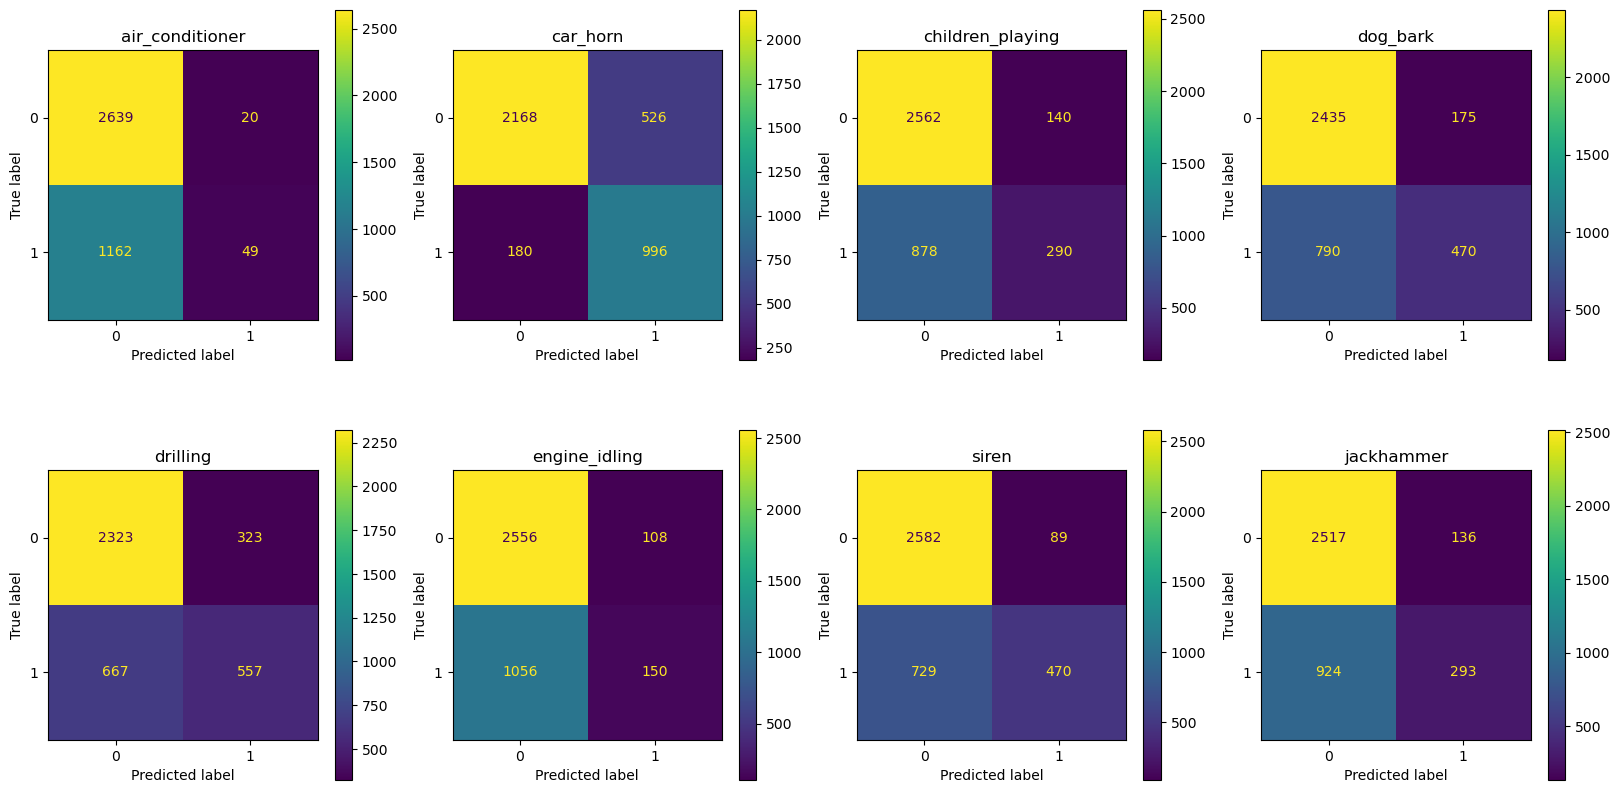

                  precision    recall  f1-score   support

 air_conditioner       0.71      0.04      0.08      1211
        car_horn       0.65      0.85      0.74      1176
children_playing       0.67      0.25      0.36      1168
        dog_bark       0.73      0.37      0.49      1260
        drilling       0.63      0.46      0.53      1224
   engine_idling       0.58      0.12      0.20      1206
           siren       0.84      0.39      0.53      1199
      jackhammer       0.68      0.24      0.36      1217

       micro avg       0.68      0.34      0.45      9661
       macro avg       0.69      0.34      0.41      9661
    weighted avg       0.69      0.34      0.41      9661
     samples avg       0.64      0.35      0.43      9661

Checkpoint saved at 'checkpoint\checkpoint_spectralv2_epoch_0'
Model improved. Saving the model...


Epoch 2/5 Validation Loss: 1.1162: 100%|██████████| 121/121 [02:16<00:00,  1.13s/it]


Epoch 2/5 Validation Loss: 1.1162, Validation Accuracy: 0.7757


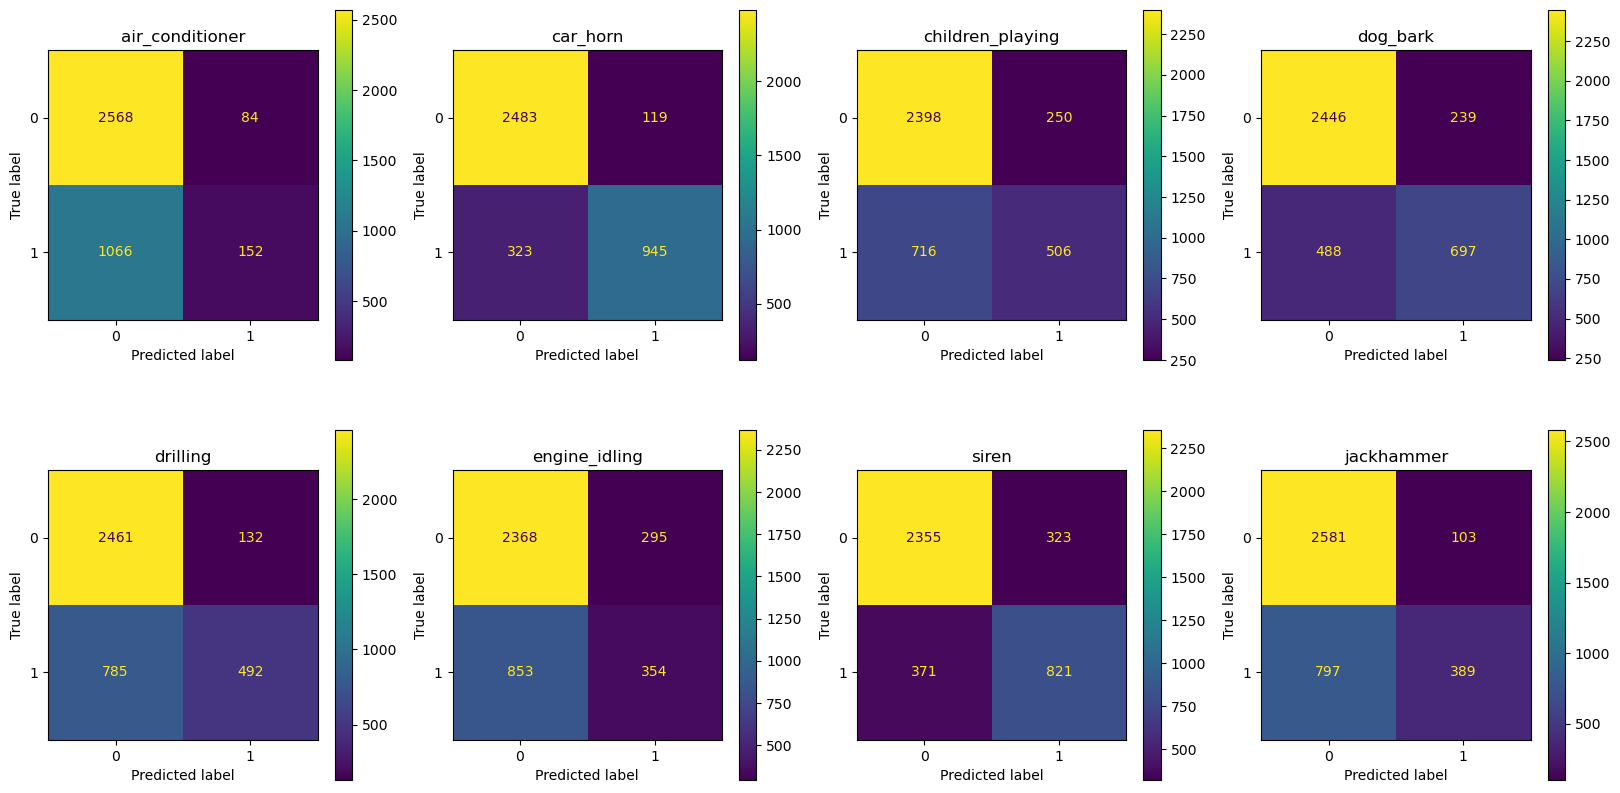

                  precision    recall  f1-score   support

 air_conditioner       0.64      0.12      0.21      1218
        car_horn       0.89      0.75      0.81      1268
children_playing       0.67      0.41      0.51      1222
        dog_bark       0.74      0.59      0.66      1185
        drilling       0.79      0.39      0.52      1277
   engine_idling       0.55      0.29      0.38      1207
           siren       0.72      0.69      0.70      1192
      jackhammer       0.79      0.33      0.46      1186

       micro avg       0.74      0.45      0.56      9755
       macro avg       0.72      0.45      0.53      9755
    weighted avg       0.72      0.45      0.53      9755
     samples avg       0.75      0.46      0.54      9755

Checkpoint saved at 'checkpoint\checkpoint_spectralv2_epoch_1'
Model improved. Saving the model...


Epoch 3/5 Validation Loss: 1.2044: 100%|██████████| 121/121 [02:08<00:00,  1.06s/it]


Epoch 3/5 Validation Loss: 1.2044, Validation Accuracy: 0.7848


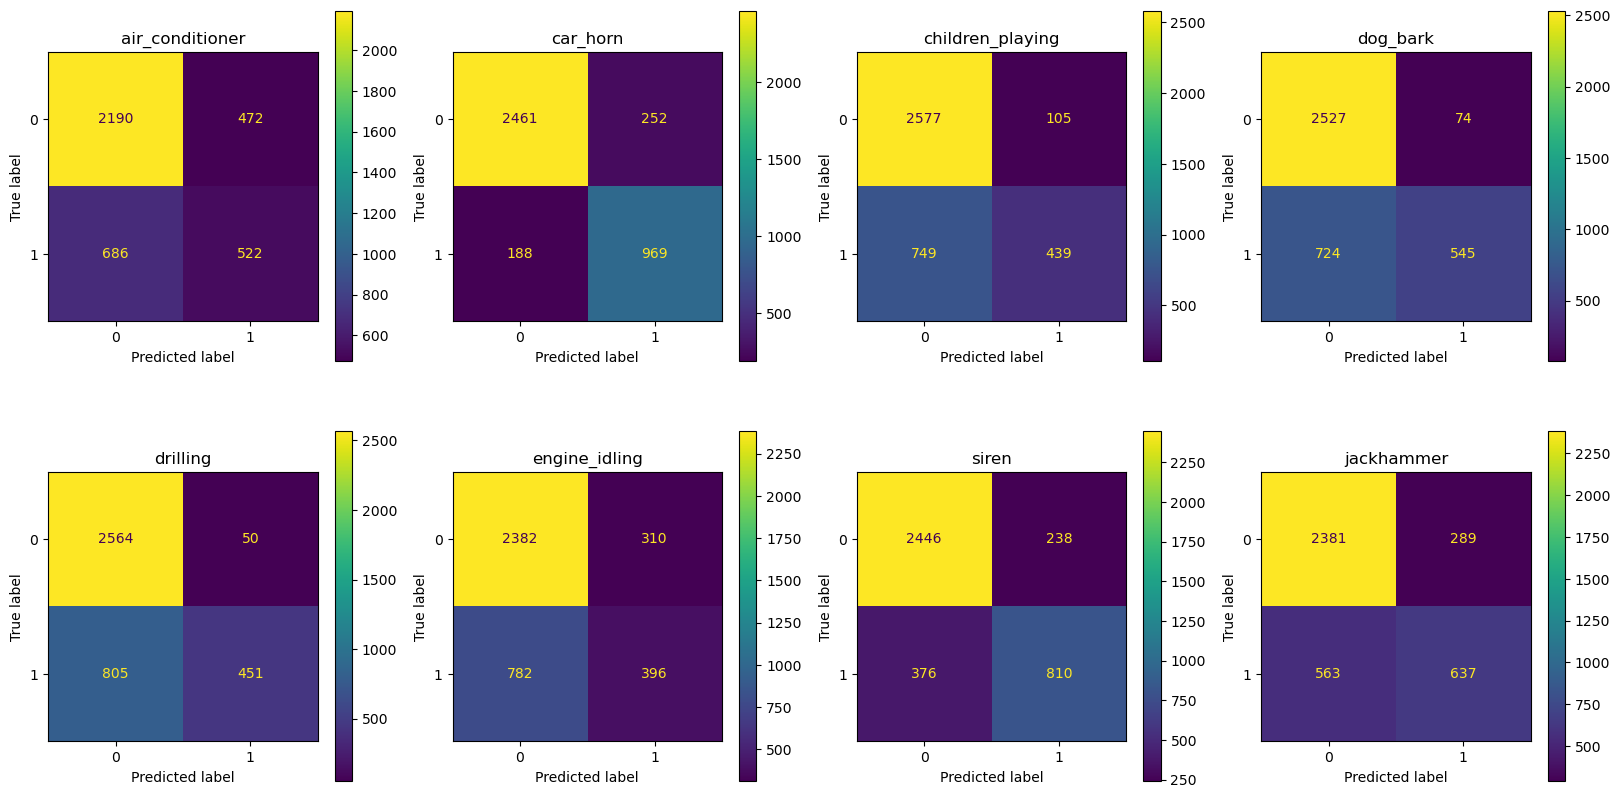

                  precision    recall  f1-score   support

 air_conditioner       0.53      0.43      0.47      1208
        car_horn       0.79      0.84      0.81      1157
children_playing       0.81      0.37      0.51      1188
        dog_bark       0.88      0.43      0.58      1269
        drilling       0.90      0.36      0.51      1256
   engine_idling       0.56      0.34      0.42      1178
           siren       0.77      0.68      0.73      1186
      jackhammer       0.69      0.53      0.60      1200

       micro avg       0.73      0.49      0.59      9642
       macro avg       0.74      0.50      0.58      9642
    weighted avg       0.74      0.49      0.58      9642
     samples avg       0.76      0.51      0.58      9642

Checkpoint saved at 'checkpoint\checkpoint_spectralv2_epoch_2'


Epoch 4/5 Validation Loss: 1.1480: 100%|██████████| 121/121 [02:06<00:00,  1.05s/it]


Epoch 4/5 Validation Loss: 1.1480, Validation Accuracy: 0.7992


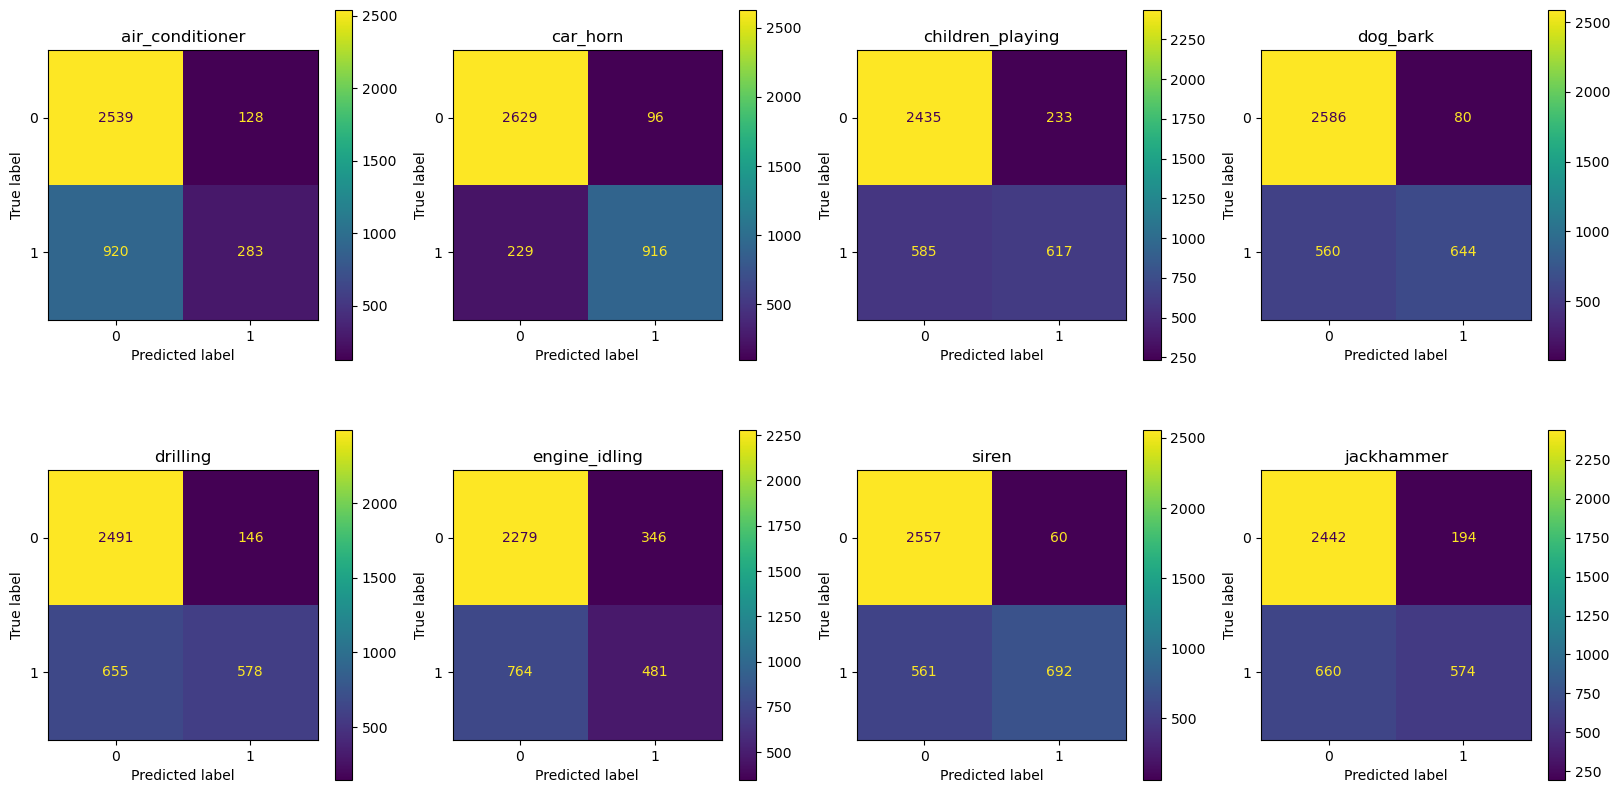

                  precision    recall  f1-score   support

 air_conditioner       0.69      0.24      0.35      1203
        car_horn       0.91      0.80      0.85      1145
children_playing       0.73      0.51      0.60      1202
        dog_bark       0.89      0.53      0.67      1204
        drilling       0.80      0.47      0.59      1233
   engine_idling       0.58      0.39      0.46      1245
           siren       0.92      0.55      0.69      1253
      jackhammer       0.75      0.47      0.57      1234

       micro avg       0.79      0.49      0.61      9719
       macro avg       0.78      0.49      0.60      9719
    weighted avg       0.78      0.49      0.60      9719
     samples avg       0.80      0.51      0.59      9719

Checkpoint saved at 'checkpoint\checkpoint_spectralv2_epoch_3'


Epoch 5/5 Validation Loss: 1.0721: 100%|██████████| 121/121 [02:02<00:00,  1.02s/it]


Epoch 5/5 Validation Loss: 1.0721, Validation Accuracy: 0.8091


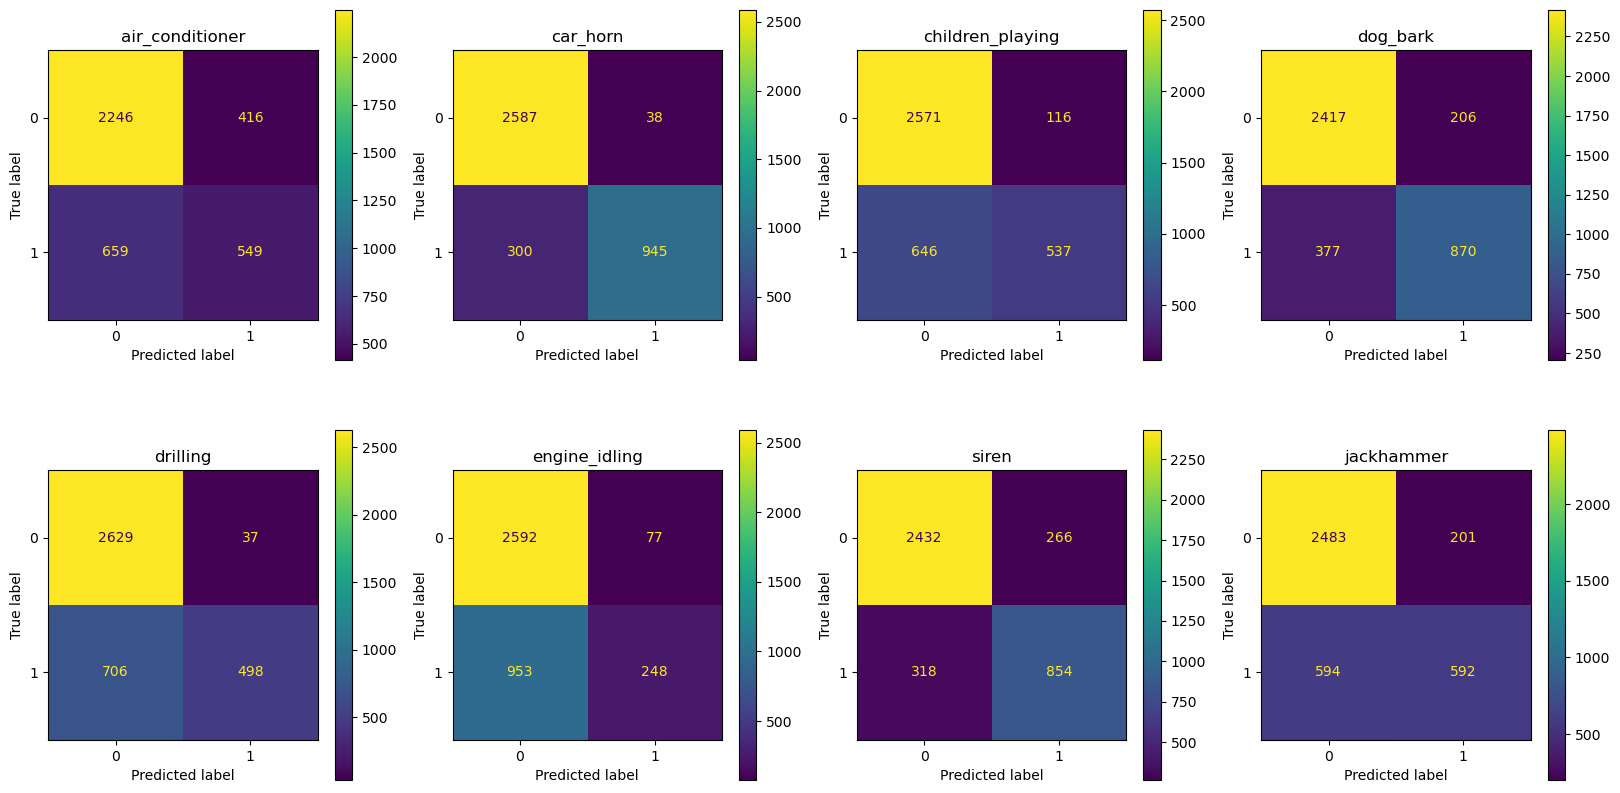

                  precision    recall  f1-score   support

 air_conditioner       0.57      0.45      0.51      1208
        car_horn       0.96      0.76      0.85      1245
children_playing       0.82      0.45      0.58      1183
        dog_bark       0.81      0.70      0.75      1247
        drilling       0.93      0.41      0.57      1204
   engine_idling       0.76      0.21      0.33      1201
           siren       0.76      0.73      0.75      1172
      jackhammer       0.75      0.50      0.60      1186

       micro avg       0.79      0.53      0.63      9646
       macro avg       0.80      0.53      0.62      9646
    weighted avg       0.80      0.53      0.62      9646
     samples avg       0.81      0.54      0.62      9646

Checkpoint saved at 'checkpoint\checkpoint_spectralv2_epoch_4'
Model improved. Saving the model...


In [ ]:
# %%

# Train the model

train_losses = []
val_losses = []
best_val_loss = np.inf
patience = 5
num_epochs = 5

# model, optimizer, start_epoch, loss = load_checkpoint(model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_air_engine_epoch_3.pth')
# model, optimizer, start_epoch, loss = load_checkpoint(model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_air_engine_spectralv1_epoch_2.pth')
# model, optimizer, start_epoch, loss = load_checkpoint(
#     model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_spectral_epoch_2.pth')

start_epoch = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {
                     epoch + 1}/{num_epochs} Training Loss: {train_loss:.4f}", colour='green')
    for i, batch in enumerate(train_bar):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Move data to device
        # mixture = batch['mixture_audio'].to(device)
        # true_percussion = batch['percussion_audio'].to(device)
        mix_stft = batch['mix_stft'].to(device)
        true_percussion_stft = batch['perc_stft'].to(device)

        # true_class = batch['noise_class'].to(device)
        # ici true class est un tensor de taille (batch_size, 8) avec des 0 et des 1 pour les classes présentes et absentes
        true_class = batch['noise_labels'].to(device)

        # Forward pass
        output, class_output = model(torch.abs(mix_stft))

        # Reconstruct the complex spectrogram
        sep_output = SpectrogramReconstructor().reconstruct(
            output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
        # percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

        # Calculate the loss
        # loss = criterion(percussion_sep, class_output, true_percussion, true_class)
        loss = criterion(sep_output, class_output, true_percussion_stft,
                         true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

        # Backward pass
        loss.backward()
        optimizer.step()

        # else we calculate log spectral loss so we need to calculate the stft of the separated percussion (sep_output is the complex spectrogram of the separated percussion)
        # true_percussion_stft = torch.stft(true_percussion, n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(window_length=256, device=device), return_complex=True)

        train_loss += loss.item()
        train_bar.set_description(
            f"Epoch {epoch + 1}/{num_epochs} Training Loss: {train_loss/(i+1):.4f}")

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0

    # confusion matrix for multilabel classification
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    val_bar = tqdm(val_loader, desc=f"Epoch {
        epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}", colour='red')
    with torch.no_grad():
        for i, batch in enumerate(val_bar):
            # Move data to device
            # mixture = batch['mixture_audio'].to(device)
            mix_stft = batch['mix_stft'].to(device)
            # true_percussion = batch['percussion_audio'].to(device)
            true_percussion_stft = batch['perc_stft'].to(device)
            true_class = batch['noise_labels'].to(device)

            # Forward pass
            output, class_output = model(torch.abs(mix_stft))

            # Reconstruct the complex spectrogram
            sep_output = SpectrogramReconstructor().reconstruct(
                output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
            # percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

            # Calculate the loss
            # loss = criterion(percussion_sep, class_output, true_percussion, true_class)
            loss = criterion(sep_output, class_output, true_percussion_stft,
                             true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

            val_loss += loss.item()

            # Calculate multi-label classification accuracy
            predicted = (torch.sigmoid(class_output) > 0.5).float()
            # Total for a multi-label classification:
            total += true_class.size(0) * true_class.size(1)
            correct += (predicted == true_class).float().sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true_class.cpu().numpy())

            val_bar.set_description(
                f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss/(i+1):.4f}")

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / total

        print(f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {
              val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

        # confusion matrix
        labels = ['air_conditioner', 'car_horn', 'children_playing',
                  'dog_bark', 'drilling', 'engine_idling', 'siren', 'jackhammer']
        cm = multilabel_confusion_matrix(all_labels, all_preds)

        # plot confusion matrix
        from sklearn.metrics import ConfusionMatrixDisplay
        fig, ax = plt.subplots(2, 4, figsize=(20, 10))
        for i in range(8):
            disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
            disp.plot(ax=ax[i//4, i % 4])
            disp.ax_.set_title(labels[i])
        plt.show()

        # classification report multilabel
        print(classification_report(all_labels, all_preds,
              target_names=labels, zero_division=0))

        # save checkpoint
        save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_dir='checkpoint',
                        filename='checkpoint_spectralv2_epoch_{}'.format(epoch))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model.pth')
            torch.save(model.state_dict(), 'best_model_spectralv2.pth')
            print("Model improved. Saving the model...")

        else:
            patience -= 1
            if patience == 0:
                print("Early stopping")
                break

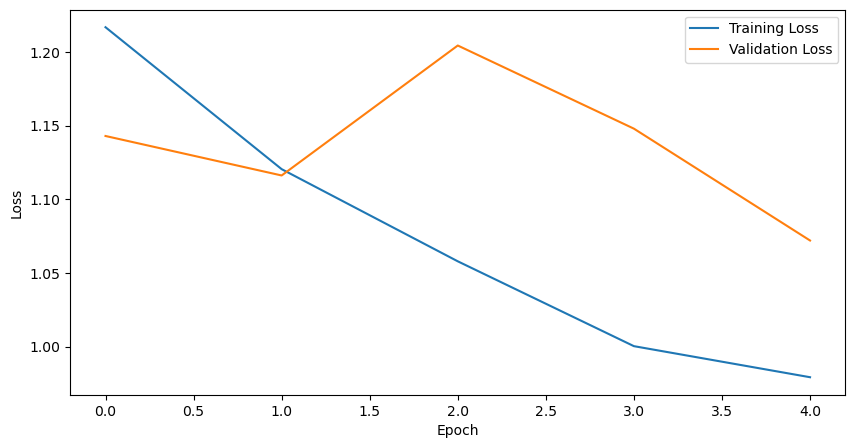

In [ ]:
# %%

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# %%

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, hamming_loss

# on utilise precision_recall_fscore_support pour calculer les scores de précision, recall et f1-score (multi-label)
# accuracy_score pour calculer l'accuracy (multi-label) 
# hamming_loss pour calculer la hamming loss (multi-label)

# on utilise classification_report pour afficher les résultats
# on utilise multilabel_confusion_matrix pour afficher les matrices

# Test the model
model.eval()
test_loss = 0
test_losses = []
# confusion matrix for multilabel classification
correct = 0
total = 0
all_preds = []
all_labels = []

test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}", colour='red')
with torch.no_grad():
    for i, batch in enumerate(test_bar):
        # Move data to device
        # mixture = batch['mixture_audio'].to(device)
        mix_stft = batch['mix_stft'].to(device)
        # true_percussion = batch['percussion_audio'].to(device)
        true_percussion_stft = batch['perc_stft'].to(device)
        true_class = batch['noise_labels'].to(device)

        # Forward pass
        output, class_output = model(torch.abs(mix_stft))

        # Reconstruct the complex spectrogram
        sep_output = SpectrogramReconstructor().reconstruct(
            output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
        # percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

        # Calculate the loss
        # loss = criterion(percussion_sep, class_output, true_percussion, true_class)
        loss = criterion(sep_output, class_output, true_percussion_stft,
                         true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

        test_loss += loss.item()

        # Calculate multi-label classification accuracy
        predicted = (torch.sigmoid(class_output) > 0.5).float()
        # Total for a multi-label classification:
        total += true_class.size(0) * true_class.size(1)
        correct += (predicted == true_class).float().sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(true_class.cpu().numpy())

        test_bar.set_description(
            f"Testing Loss: {test_loss/(i+1):.4f}")

    test_loss /= len(test_loader)   
    test_losses.append(test_loss)
    accuracy = correct / total
    
    # accuracy score multi-label
    accuracy_m = accuracy_score(all_labels, all_preds, sample_weight=[1, 2, 1, 1, 1, 1, 1, 1])
    # hamming loss multi-label
    hamming = hamming_loss(all_labels, all_preds, sample_weight=[1, 2, 1, 1, 1, 1, 1, 1])
    # precision, recall, f1-score multi-label
    precision, recall, f1, true_sum = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    
    print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {accuracy:.4f}")
    print(f"Testing Accuracy (multi-label): {accuracy_m:.4f}")
    print(f"Hamming Loss (multi-label): {hamming:.4f}")
    print(f"Precision (multi-label): {precision:.4f}")
    print(f"Recall (multi-label): {recall:.4f}")
    print(f"F1-score (multi-label): {f1:.4f}")
    
    # confusion matrix
    labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'siren', 'jackhammer']
    cm = multilabel_confusion_matrix(all_labels, all_preds, sample_weight=[1, 2, 1, 1, 1, 1, 1, 1], labels=[0, 1])
    
    # plot confusion matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    for i in range(8):
        disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
        disp.plot(ax=ax[i//4, i % 4])
        disp.ax_.set_title(labels[i])
    plt.show()
    
    # classification report multilabel
    print(classification_report(all_labels, all_preds, target_names=labels, zero_division=0))
    
    # save the results
    results = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'accuracy_m': accuracy_m,
        'hamming': hamming,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    np.save('results_spectralv2.npy', results)

Testing Loss: 1.0813: 100%|██████████| 323/323 [02:19<00:00,  2.32it/s]


ValueError: Found input variables with inconsistent numbers of samples: [3870, 3870, 8]

Testing Loss: 1.0813, Testing Accuracy: 0.8040
Testing Accuracy (multi-label): 0.1276
Hamming Loss (multi-label): 0.1960
Precision (multi-label): 0.7819
Recall (multi-label): 0.5239
F1-score (multi-label): 0.6112


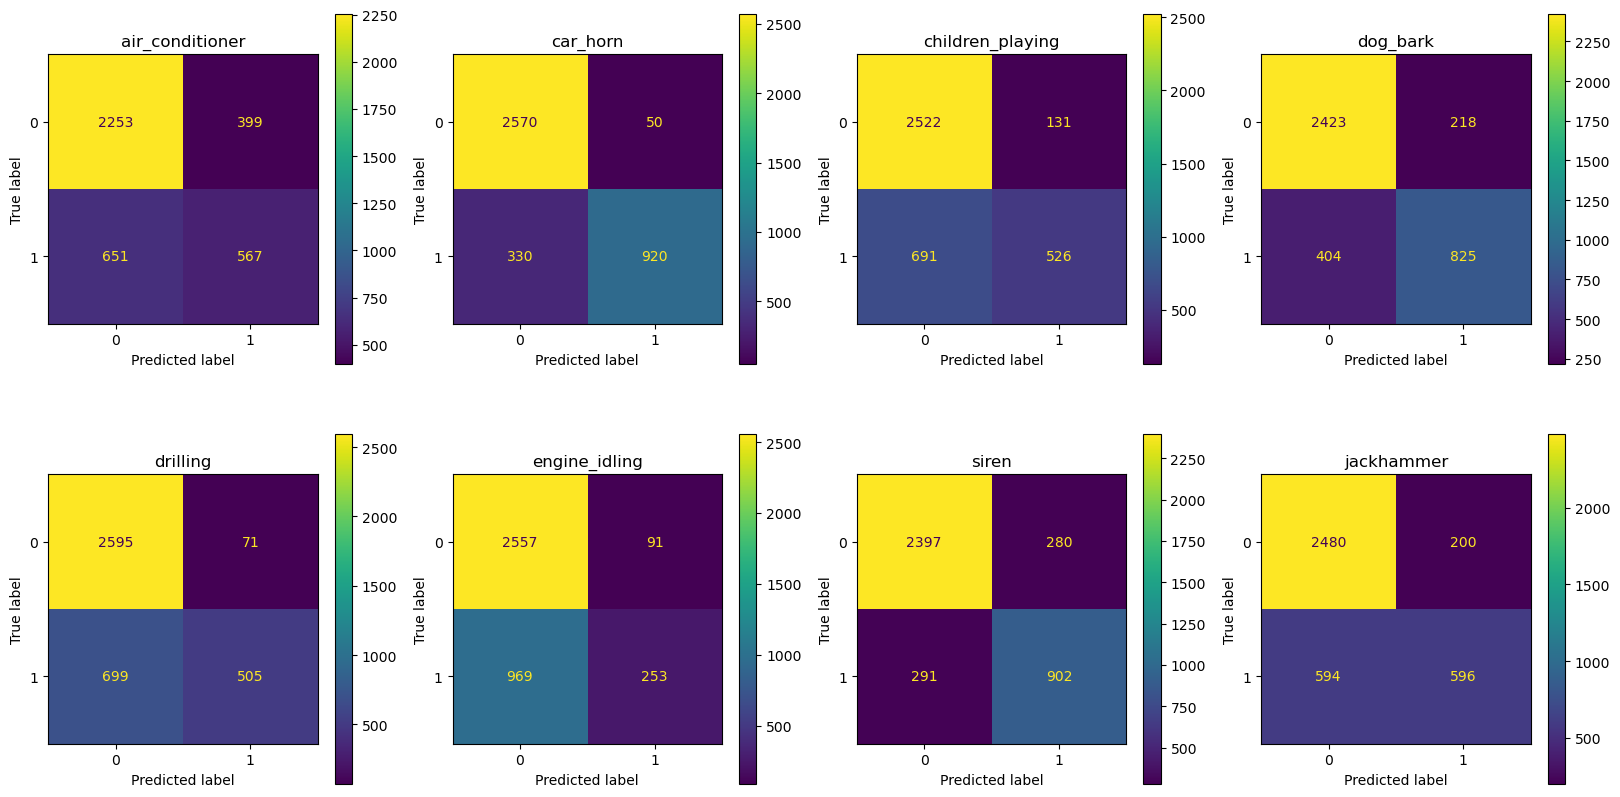

                  precision    recall  f1-score   support

 air_conditioner       0.59      0.47      0.52      1218
        car_horn       0.95      0.74      0.83      1250
children_playing       0.80      0.43      0.56      1217
        dog_bark       0.79      0.67      0.73      1229
        drilling       0.88      0.42      0.57      1204
   engine_idling       0.74      0.21      0.32      1222
           siren       0.76      0.76      0.76      1193
      jackhammer       0.75      0.50      0.60      1190

       micro avg       0.78      0.52      0.63      9723
       macro avg       0.78      0.52      0.61      9723
    weighted avg       0.78      0.52      0.61      9723
     samples avg       0.80      0.54      0.62      9723



In [ ]:
#%%

# accuracy score multi-label
accuracy_m = accuracy_score(all_labels, all_preds)
# hamming loss multi-label
hamming = hamming_loss(all_labels, all_preds)
# precision, recall, f1-score multi-label
precision, recall, f1, true_sum = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {accuracy:.4f}")
print(f"Testing Accuracy (multi-label): {accuracy_m:.4f}")
print(f"Hamming Loss (multi-label): {hamming:.4f}")
print(f"Precision (multi-label): {precision:.4f}")
print(f"Recall (multi-label): {recall:.4f}")
print(f"F1-score (multi-label): {f1:.4f}")

# confusion matrix
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'siren', 'jackhammer']
cm = multilabel_confusion_matrix(all_labels, all_preds)

# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=ax[i//4, i % 4])
    disp.ax_.set_title(labels[i])
plt.show()

# classification report multilabel
print(classification_report(all_labels, all_preds, target_names=labels, zero_division=0))

# save the results
results = {
    'test_loss': test_loss,
    'accuracy': accuracy,
    'accuracy_m': accuracy_m,
    'hamming': hamming,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

np.save('results_spectralv2.npy', results)

<ipython-input-56-753064635cc2>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_spectralv2.pth'))


Testing Loss: 1.0800, Testing Accuracy: 0.8542
Testing Accuracy (multi-label): 0.4167
Hamming Loss (multi-label): 0.1458
Precision (multi-label): 0.7069
Recall (multi-label): 0.6552
F1-score (multi-label): 0.6739


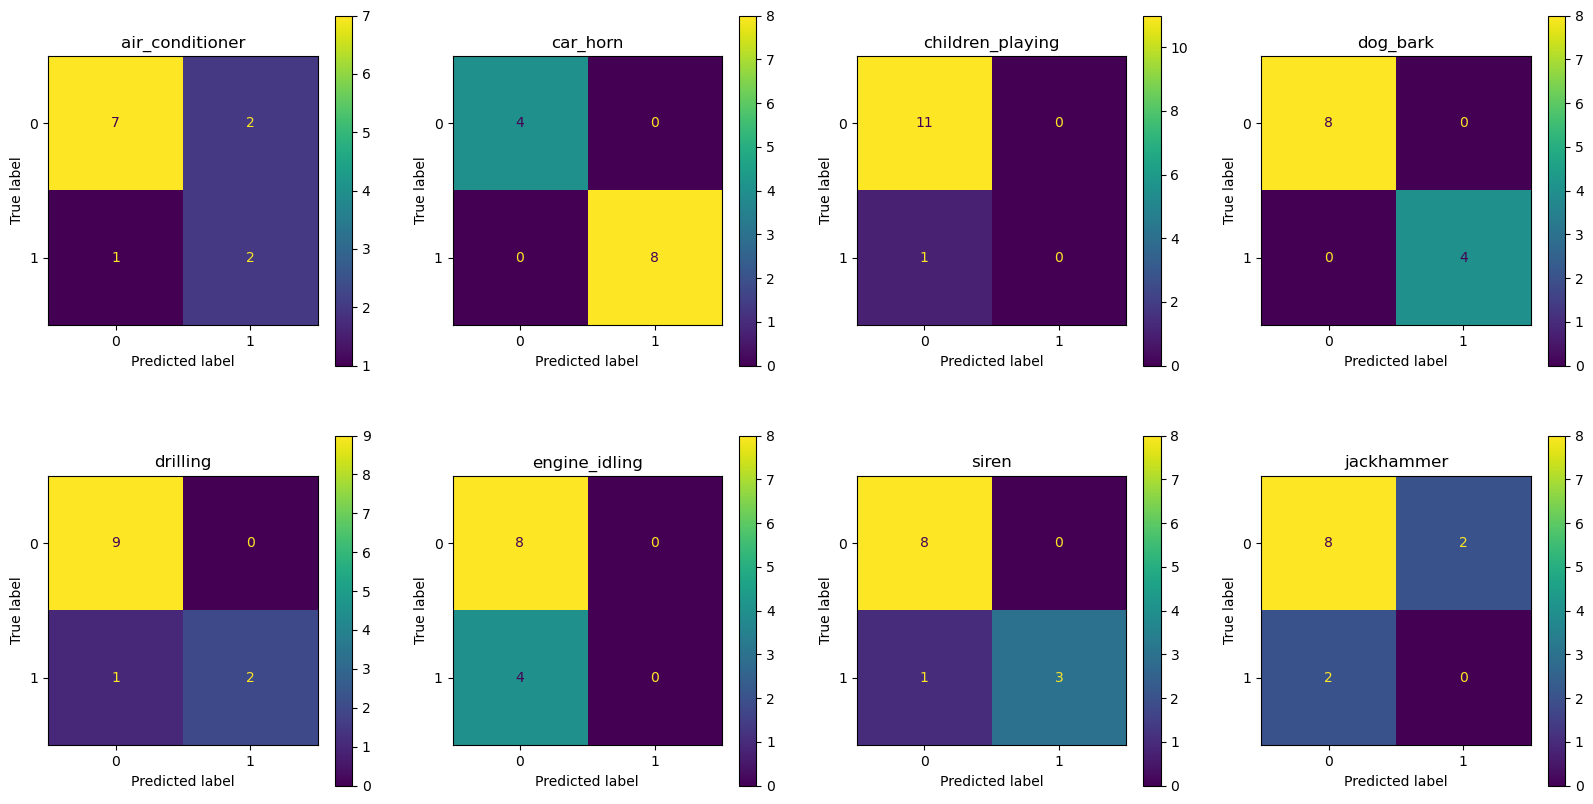

                  precision    recall  f1-score   support

 air_conditioner       0.50      0.67      0.57         3
        car_horn       1.00      1.00      1.00         8
children_playing       0.00      0.00      0.00         1
        dog_bark       1.00      1.00      1.00         4
        drilling       1.00      0.67      0.80         3
   engine_idling       0.00      0.00      0.00         4
           siren       1.00      0.75      0.86         4
      jackhammer       0.00      0.00      0.00         2

       micro avg       0.83      0.66      0.73        29
       macro avg       0.56      0.51      0.53        29
    weighted avg       0.71      0.66      0.67        29
     samples avg       0.83      0.68      0.74        29



In [ ]:
# %%

# inference on a single audio file
# load the model
model = ResUNet(in_c=1, out_c=16).to("cuda")
model.load_state_dict(torch.load('best_model_spectralv2.pth'))
model.eval()

# load a test file from the test loader
test_file = next(iter(test_loader))
mix_stft = test_file['mix_stft'].to(device)
mixture_audio = test_file['mixture_audio'].to(device)
percussion_audio = test_file['percussion_audio'].to(device)
true_percussion_stft = test_file['perc_stft'].to(device)
true_class = test_file['noise_labels'].to(device)

# forward pass
output, class_output = model(torch.abs(mix_stft))

# reconstruct the complex spectrogram
sep_output = SpectrogramReconstructor().reconstruct(
    output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

# calculate the loss
loss = criterion(sep_output, class_output, true_percussion_stft,
                 true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

# calculate multi-label classification accuracy
predicted = (torch.sigmoid(class_output) > 0.5).float()
# total for a multi-label classification:
total = true_class.size(0) * true_class.size(1)
correct = (predicted == true_class).float().sum().item()

# confusion matrix for multilabel classification
all_preds = []
all_labels = []
all_preds.extend(predicted.cpu().numpy())
all_labels.extend(true_class.cpu().numpy())

# accuracy score for correctly predicting positive and negative classes
accuracy_m = accuracy_score(all_labels, all_preds)

# hamming loss multi-label
hamming = hamming_loss(all_labels, all_preds)
# precision, recall, f1-score multi-label
precision, recall, f1, true_sum = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Testing Loss: {loss:.4f}, Testing Accuracy: {correct/total:.4f}")
print(f"Testing Accuracy (multi-label): {accuracy_m:.4f}")
print(f"Hamming Loss (multi-label): {hamming:.4f}")
print(f"Precision (multi-label): {precision:.4f}")
print(f"Recall (multi-label): {recall:.4f}")
print(f"F1-score (multi-label): {f1:.4f}")

# confusion matrix
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'siren', 'jackhammer']
cm = multilabel_confusion_matrix(all_labels, all_preds)

# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=ax[i//4, i % 4])
    disp.ax_.set_title(labels[i])
plt.show()

# classification report multilabel
print(classification_report(all_labels, all_preds, target_names=labels, zero_division=0))

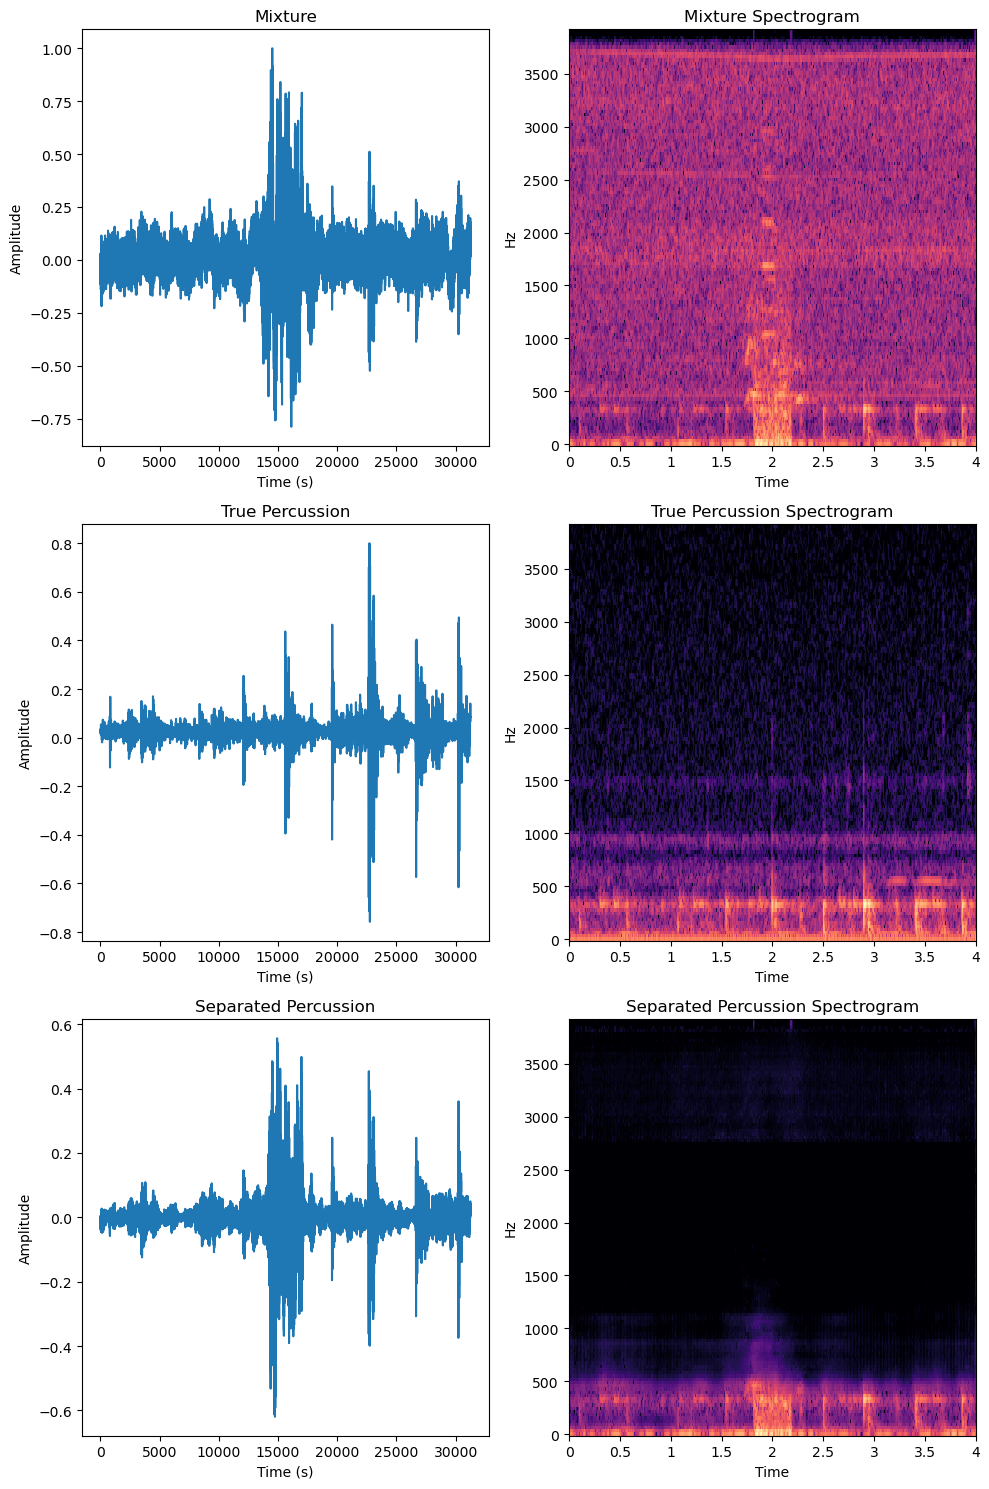

In [ ]:
# %%

k = np.random.randint(0, 12)

# plot the mixture, separated percussion and true percussion
plt.figure(figsize=(10, 15))

plt.subplot(3, 2, 1)
plt.title('Mixture')
plt.plot(mixture_audio[k].cpu().numpy())
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 2, 3)
plt.title('True Percussion')
plt.plot(percussion_audio[k].cpu().numpy())
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 2, 5)
plt.title('Separated Percussion')
plt.plot(percussion_sep[k].detach().cpu().numpy())
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 2, 2)
plt.title('Mixture Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(mix_stft[k].detach().cpu().numpy()), ref=np.max), y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)

plt.subplot(3, 2, 4)
plt.title('True Percussion Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(true_percussion_stft[k].detach().cpu().numpy()), ref=np.max), y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)

plt.subplot(3, 2, 6)
plt.title('Separated Percussion Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(sep_output[k].detach().cpu().numpy()), ref=np.max), y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)

plt.tight_layout()
plt.show()

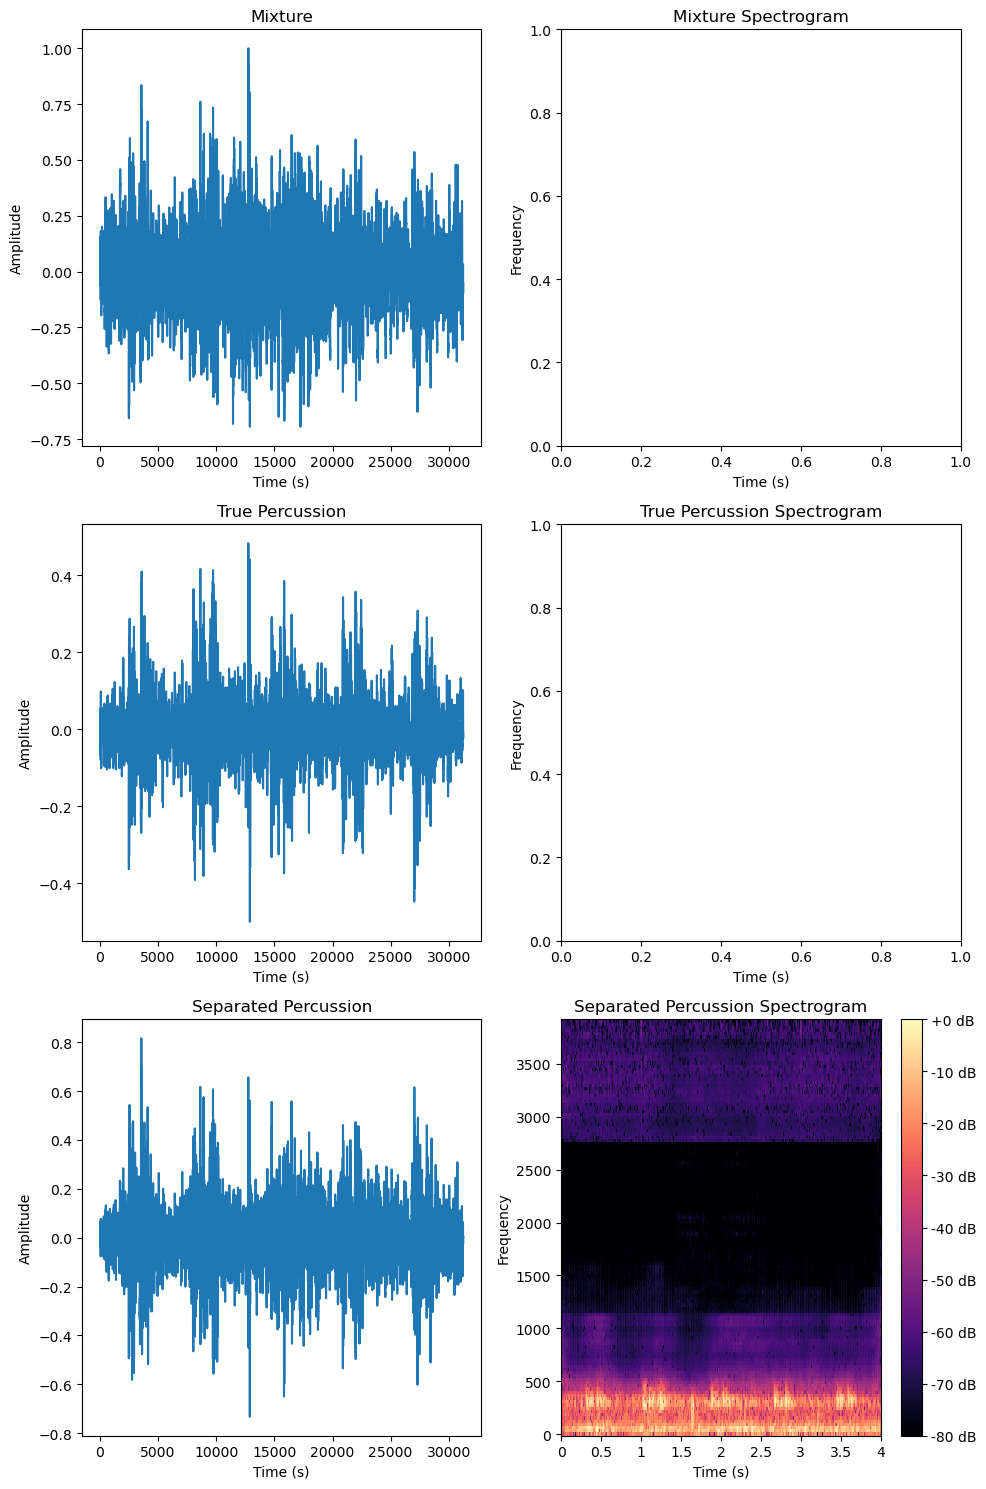

In [ ]:
# %%

k = np.random.randint(0, 12)

# Plot the mixture, separated percussion, and true percussion
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

axs[0, 0].set_title('Mixture')
axs[0, 0].plot(mixture_audio[k].cpu().numpy())
axs[0, 0].set(xlabel='Time (s)', ylabel='Amplitude')

axs[1, 0].set_title('True Percussion')
axs[1, 0].plot(percussion_audio[k].cpu().numpy())
axs[1, 0].set(xlabel='Time (s)', ylabel='Amplitude')

axs[2, 0].set_title('Separated Percussion')
axs[2, 0].plot(percussion_sep[k].detach().cpu().numpy())
axs[2, 0].set(xlabel='Time (s)', ylabel='Amplitude')

axs[0, 1].set_title('Mixture Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(mix_stft[k].detach().cpu().numpy()), ref=np.max), y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)
axs[0, 1].set(xlabel='Time (s)', ylabel='Frequency')

axs[1, 1].set_title('True Percussion Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(true_percussion_stft[k].detach().cpu().numpy()), ref=np.max), y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)
axs[1, 1].set(xlabel='Time (s)', ylabel='Frequency')

axs[2, 1].set_title('Separated Percussion Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(sep_output[k].detach().cpu().numpy()), ref=np.max), y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)
axs[2, 1].set(xlabel='Time (s)', ylabel='Frequency')

plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

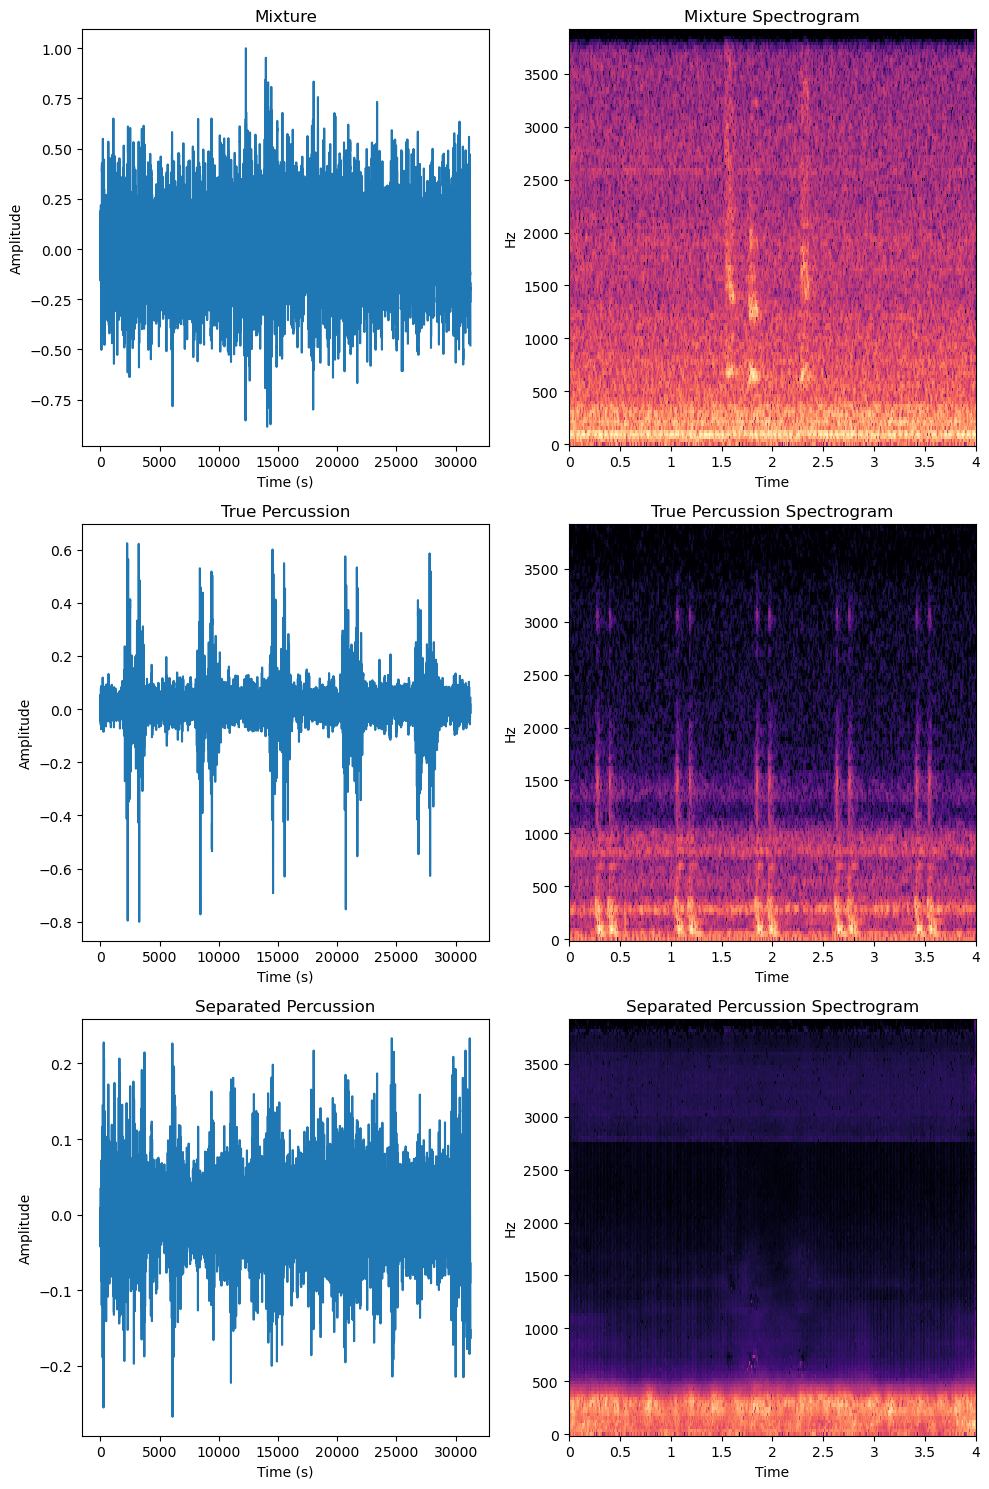

In [ ]:
# %%

k = np.random.randint(0, 12)

# Data and titles for plotting
audio_data = [
    (mixture_audio, 'Mixture'),
    (percussion_audio, 'True Percussion'),
    (percussion_sep.detach(), 'Separated Percussion')
]

spectrogram_data = [
    (mix_stft, 'Mixture Spectrogram'),
    (true_percussion_stft, 'True Percussion Spectrogram'),
    (sep_output, 'Separated Percussion Spectrogram')
]

plt.figure(figsize=(10, 15))

# Plot audio waveforms
for i, (data, title) in enumerate(audio_data):
    plt.subplot(3, 2, 2 * i + 1)
    plt.title(title)
    plt.plot(data[k].cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

# Plot spectrograms
for i, (data, title) in enumerate(spectrogram_data):
    plt.subplot(3, 2, 2 * (i + 1))
    plt.title(title)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(data[k].detach().cpu().numpy()), ref=np.max), 
                             y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)

plt.tight_layout()
plt.show()

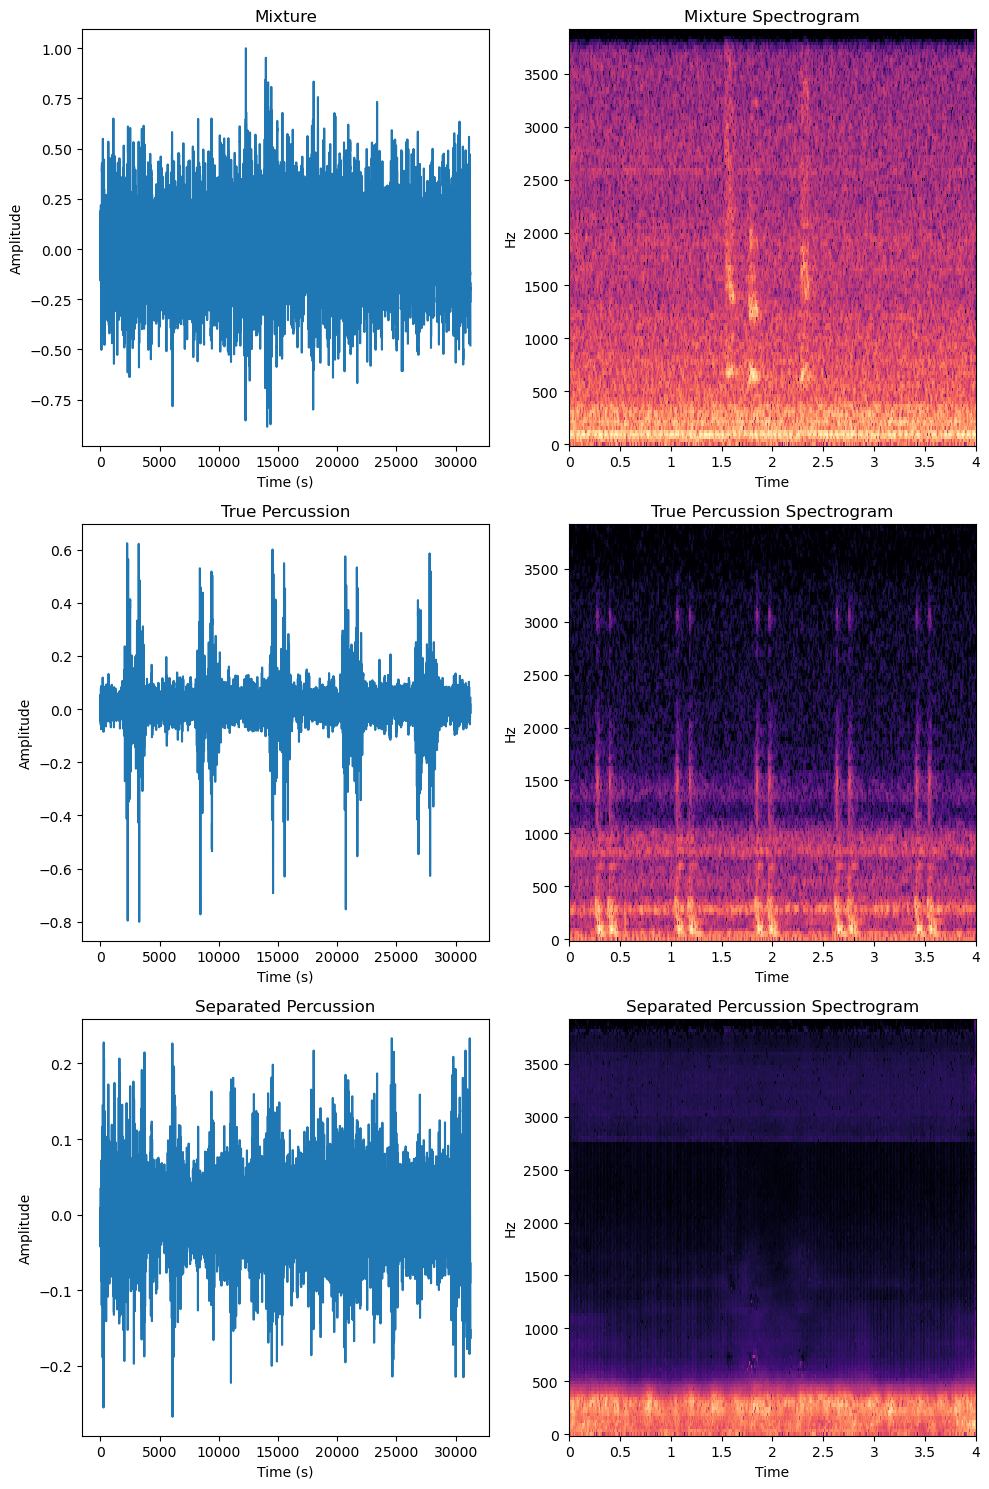

In [ ]:
# %%

k = np.random.randint(0, 12)

# Data and titles for plotting
audio_data = [
    (mixture_audio, 'Mixture'),
    (percussion_audio, 'True Percussion'),
    (percussion_sep.detach(), 'Separated Percussion')
]

spectrogram_data = [
    (mix_stft, 'Mixture Spectrogram'),
    (true_percussion_stft, 'True Percussion Spectrogram'),
    (sep_output, 'Separated Percussion Spectrogram')
]

plt.figure(figsize=(10, 15))

# Plot audio waveforms
for i, (data, title) in enumerate(audio_data):
    plt.subplot(3, 2, 2 * i + 1)
    plt.title(title)
    plt.plot(data[k].cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

# Plot spectrograms
for i, (data, title) in enumerate(spectrogram_data):
    plt.subplot(3, 2, 2 * (i + 1))
    plt.title(title)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(data[k].detach().cpu().numpy()), ref=np.max), 
                             y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)

plt.tight_layout()
plt.show()

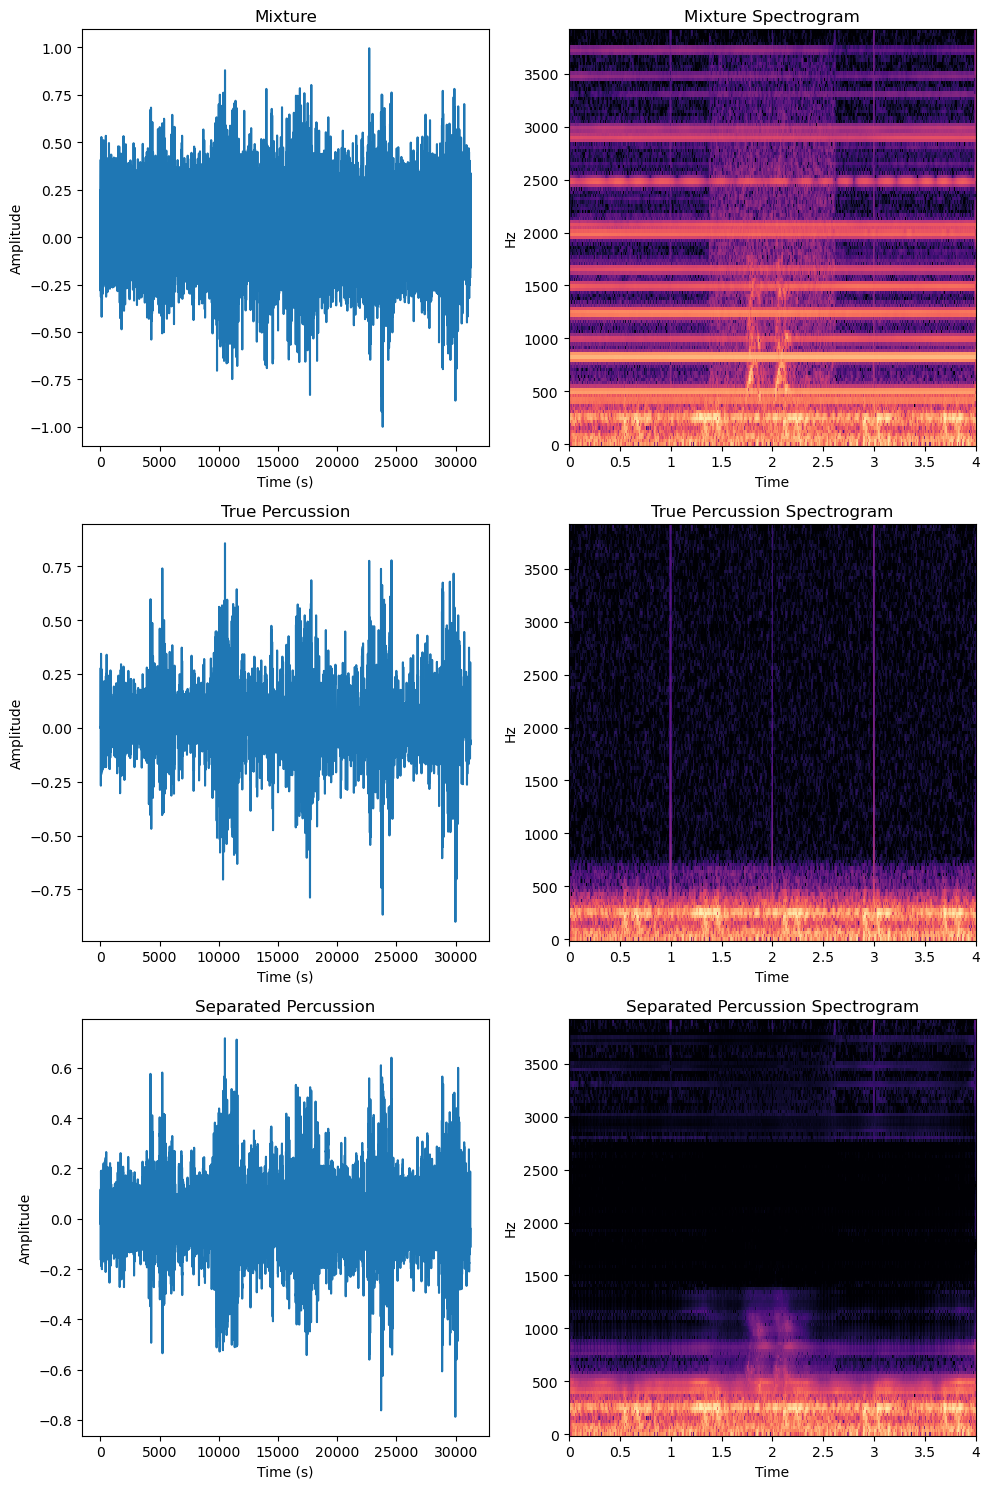

In [ ]:
# %%

k = np.random.randint(0, 12)

# Data and titles for plotting
audio_data = [
    (mixture_audio, 'Mixture'),
    (percussion_audio, 'True Percussion'),
    (percussion_sep.detach(), 'Separated Percussion')
]

spectrogram_data = [
    (mix_stft, 'Mixture Spectrogram'),
    (true_percussion_stft, 'True Percussion Spectrogram'),
    (sep_output, 'Separated Percussion Spectrogram')
]

plt.figure(figsize=(10, 15))

# Plot audio waveforms
for i, (data, title) in enumerate(audio_data):
    plt.subplot(3, 2, 2 * i + 1)
    plt.title(title)
    plt.plot(data[k].cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

# Plot spectrograms
for i, (data, title) in enumerate(spectrogram_data):
    plt.subplot(3, 2, 2 * (i + 1))
    plt.title(title)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(data[k].detach().cpu().numpy()), ref=np.max), 
                             y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)

plt.tight_layout()
plt.show()

In [ ]:
# %%

# calculate energy ratio
def energy_ratio(true_audio, separated_audio):
    true_energy = np.sum(true_audio ** 2)
    separated_energy = np.sum(separated_audio ** 2)
    ratio = separated_energy / true_energy
    return ratio

# calculate the energy ratio for the separated percussion
energy_ratios = []
for i in range(12):
    energy_ratios.append(energy_ratio(percussion_audio[i].cpu().numpy(), percussion_sep[i].detach().cpu().numpy()))
    
energy_ratios = np.array(energy_ratios)
print(f"Energy Ratios: {energy_ratios}")

Energy Ratios: [1.4943501  0.9036137  1.0871316  0.8490295  0.3025047  2.7235785
 0.9653177  0.7382691  0.94369966 0.7154265  0.36280698 0.07961367]


Energy Ratios: [1.4943501  0.9036137  1.0871316  0.8490295  0.3025047  2.7235785
 0.9653177  0.7382691  0.94369966 0.7154265  0.36280698 0.07961367]


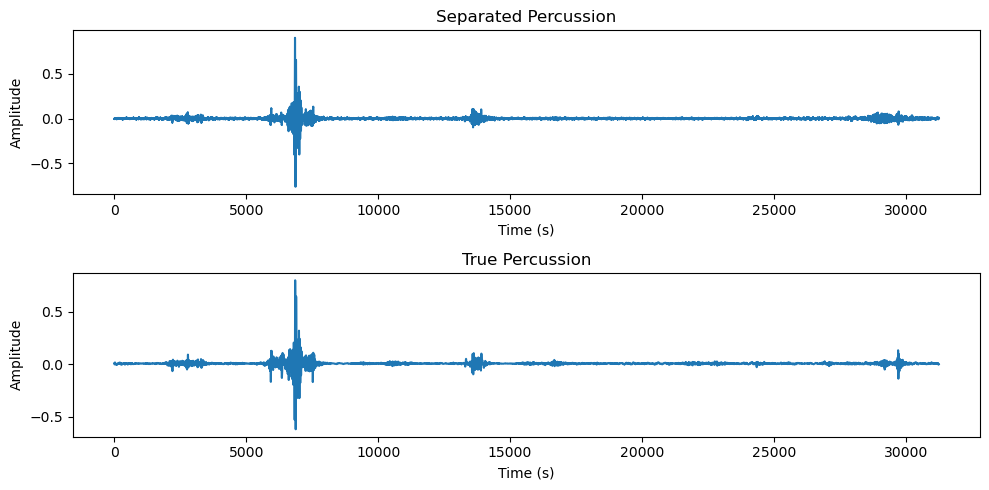

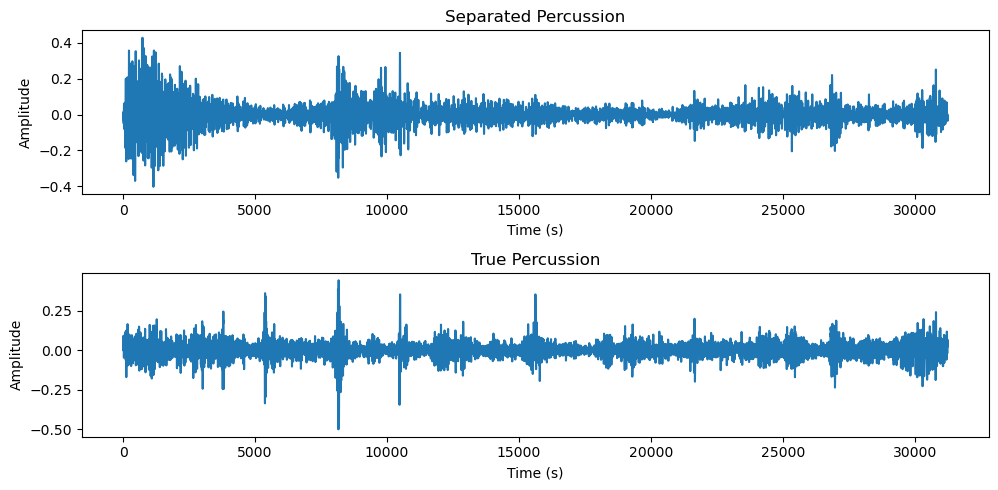

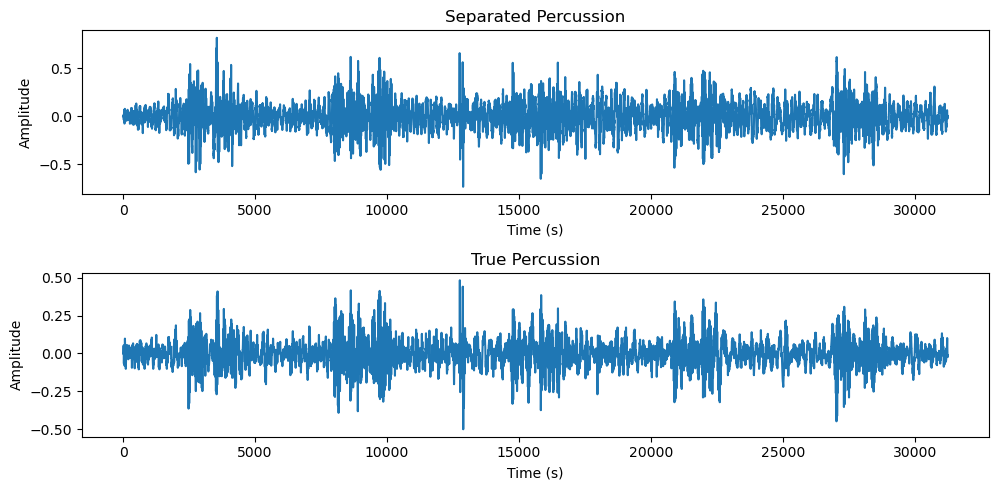

In [ ]:
# %%

# calculate energy ratio
def energy_ratio(true_audio, separated_audio):
    true_energy = np.sum(true_audio ** 2)
    separated_energy = np.sum(separated_audio ** 2)
    ratio = separated_energy / true_energy
    return ratio

# calculate the energy ratio for the separated percussion
energy_ratios = []
for i in range(12):
    energy_ratios.append(energy_ratio(percussion_audio[i].cpu().numpy(), percussion_sep[i].detach().cpu().numpy()))
    
energy_ratios = np.array(energy_ratios)
print(f"Energy Ratios: {energy_ratios}")

# plot the ones with the highest energy ratio
highest_ratio_indices = np.argsort(energy_ratios)[-3:]
for i in highest_ratio_indices:
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.title('Separated Percussion')
    plt.plot(percussion_sep[i].detach().cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.title('True Percussion')
    plt.plot(percussion_audio[i].cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

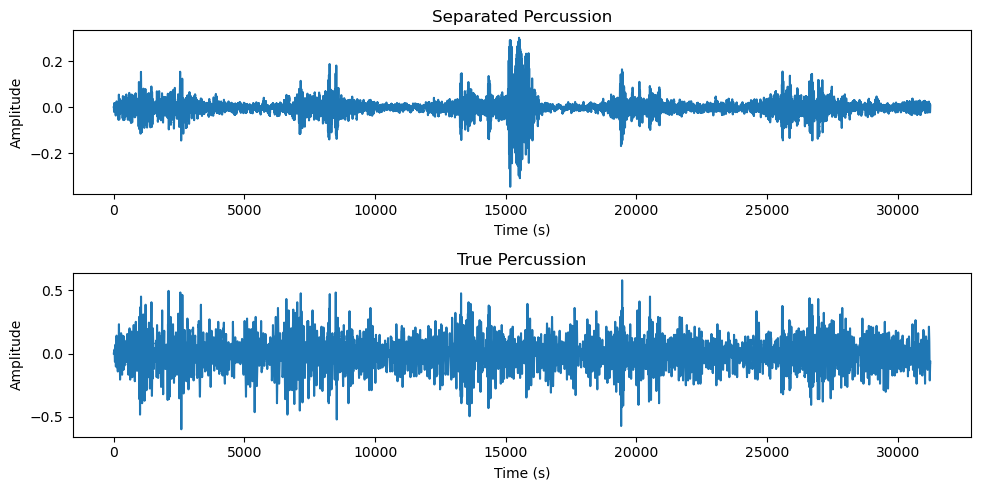

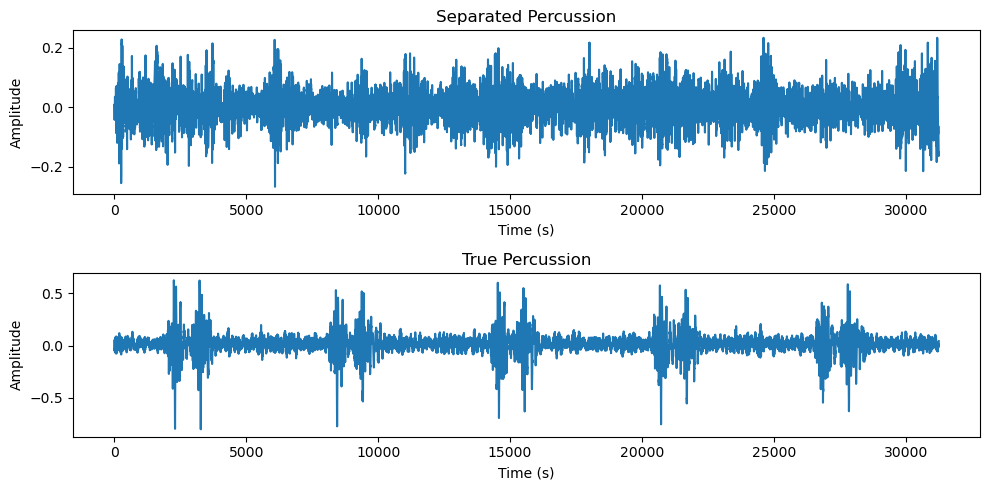

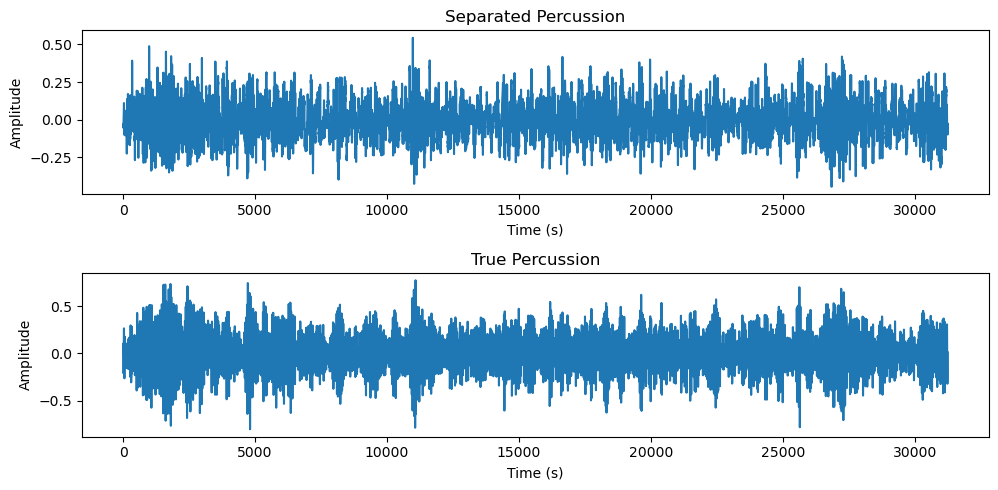

In [ ]:
#%%

# plot the ones with the lowest energy ratio
lowest_ratio_indices = np.argsort(energy_ratios)[:3]
for i in lowest_ratio_indices:
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.title('Separated Percussion')
    plt.plot(percussion_sep[i].detach().cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.title('True Percussion')
    plt.plot(percussion_audio[i].cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

<ipython-input-105-753064635cc2>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_spectralv2.pth'))


Testing Loss: 1.0545, Testing Accuracy: 0.7917
Testing Accuracy (multi-label): 0.0833
Hamming Loss (multi-label): 0.2083
Precision (multi-label): 0.7357
Recall (multi-label): 0.5000
F1-score (multi-label): 0.5294


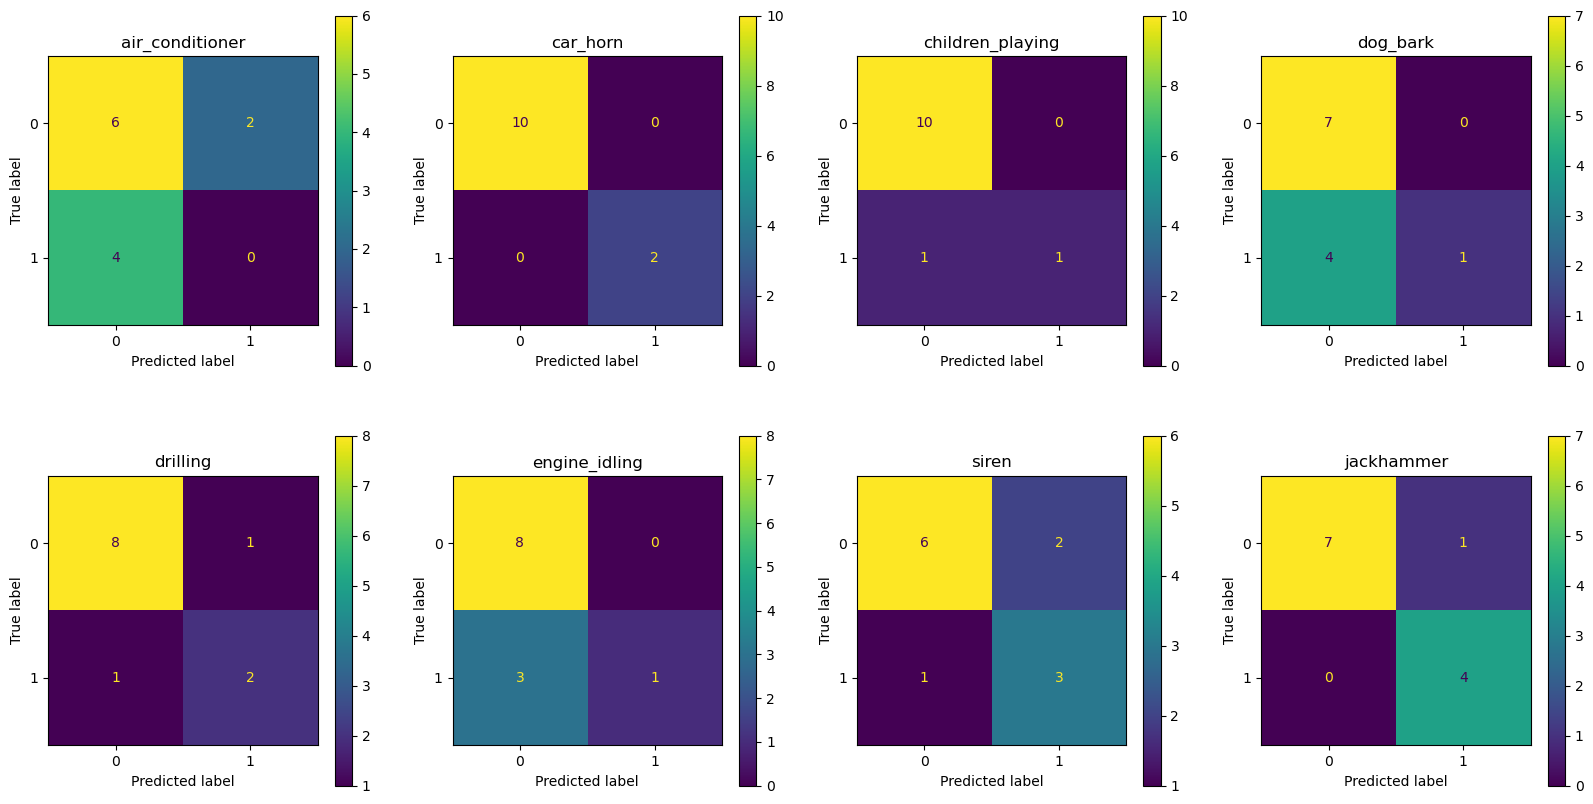

                  precision    recall  f1-score   support

 air_conditioner       0.00      0.00      0.00         4
        car_horn       1.00      1.00      1.00         2
children_playing       1.00      0.50      0.67         2
        dog_bark       1.00      0.20      0.33         5
        drilling       0.67      0.67      0.67         3
   engine_idling       1.00      0.25      0.40         4
           siren       0.60      0.75      0.67         4
      jackhammer       0.80      1.00      0.89         4

       micro avg       0.70      0.50      0.58        28
       macro avg       0.76      0.55      0.58        28
    weighted avg       0.74      0.50      0.53        28
     samples avg       0.68      0.53      0.57        28



In [ ]:
# %%

# inference on a single audio file
# load the model
model = ResUNet(in_c=1, out_c=16).to("cuda")
model.load_state_dict(torch.load('best_model_spectralv2.pth'))
model.eval()

# load a test file from the test loader
test_file = next(iter(test_loader))
mix_stft = test_file['mix_stft'].to(device)
mixture_audio = test_file['mixture_audio'].to(device)
percussion_audio = test_file['percussion_audio'].to(device)
true_percussion_stft = test_file['perc_stft'].to(device)
true_class = test_file['noise_labels'].to(device)

# forward pass
output, class_output = model(torch.abs(mix_stft))

# reconstruct the complex spectrogram
sep_output = SpectrogramReconstructor().reconstruct(
    output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

# calculate the loss
loss = criterion(sep_output, class_output, true_percussion_stft,
                 true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

# calculate multi-label classification accuracy
predicted = (torch.sigmoid(class_output) > 0.5).float()
# total for a multi-label classification:
total = true_class.size(0) * true_class.size(1)
correct = (predicted == true_class).float().sum().item()

# confusion matrix for multilabel classification
all_preds = []
all_labels = []
all_preds.extend(predicted.cpu().numpy())
all_labels.extend(true_class.cpu().numpy())

# accuracy score for correctly predicting positive and negative classes
accuracy_m = accuracy_score(all_labels, all_preds)

# hamming loss multi-label
hamming = hamming_loss(all_labels, all_preds)
# precision, recall, f1-score multi-label
precision, recall, f1, true_sum = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Testing Loss: {loss:.4f}, Testing Accuracy: {correct/total:.4f}")
print(f"Testing Accuracy (multi-label): {accuracy_m:.4f}")
print(f"Hamming Loss (multi-label): {hamming:.4f}")
print(f"Precision (multi-label): {precision:.4f}")
print(f"Recall (multi-label): {recall:.4f}")
print(f"F1-score (multi-label): {f1:.4f}")

# confusion matrix
labels = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'siren', 'jackhammer']
cm = multilabel_confusion_matrix(all_labels, all_preds)

# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=ax[i//4, i % 4])
    disp.ax_.set_title(labels[i])
plt.show()

# classification report multilabel
print(classification_report(all_labels, all_preds, target_names=labels, zero_division=0))

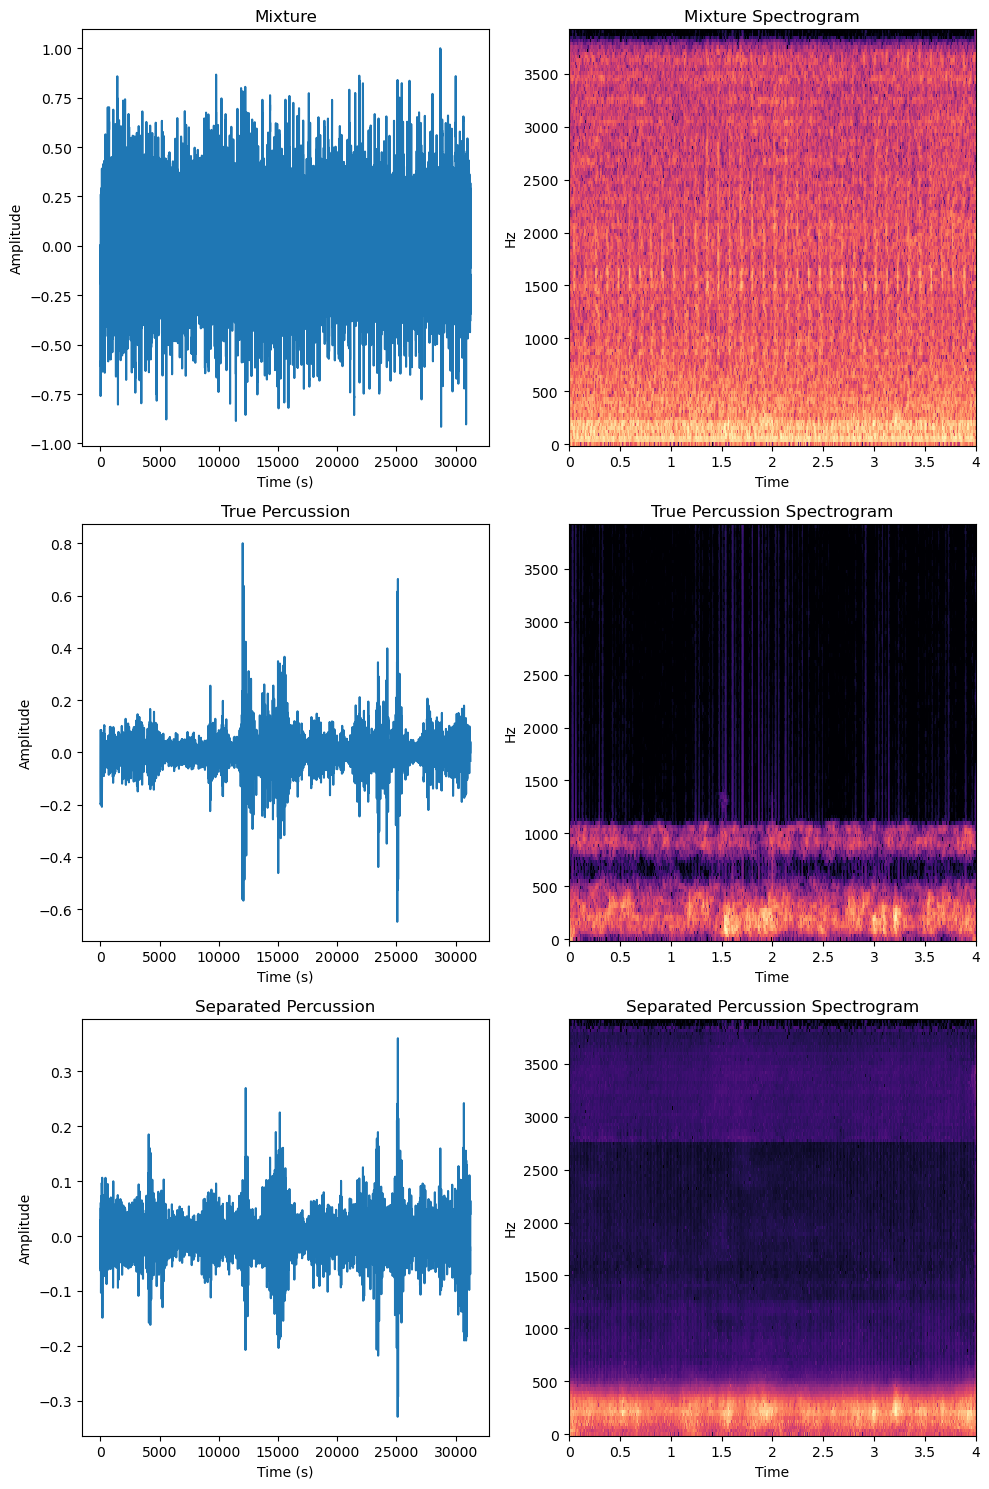

In [ ]:
# %%

k = np.random.randint(0, 12)

# Data and titles for plotting
audio_data = [
    (mixture_audio, 'Mixture'),
    (percussion_audio, 'True Percussion'),
    (percussion_sep.detach(), 'Separated Percussion')
]

spectrogram_data = [
    (mix_stft, 'Mixture Spectrogram'),
    (true_percussion_stft, 'True Percussion Spectrogram'),
    (sep_output, 'Separated Percussion Spectrogram')
]

plt.figure(figsize=(10, 15))

# Plot audio waveforms
for i, (data, title) in enumerate(audio_data):
    plt.subplot(3, 2, 2 * i + 1)
    plt.title(title)
    plt.plot(data[k].cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

# Plot spectrograms
for i, (data, title) in enumerate(spectrogram_data):
    plt.subplot(3, 2, 2 * (i + 1))
    plt.title(title)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(data[k].detach().cpu().numpy()), ref=np.max), 
                             y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)

plt.tight_layout()
plt.show()

Energy Ratios: [0.80744636 0.2837963  0.2568728  0.37749192 0.32610437 1.2192491
 1.5444592  1.4512342  0.66499466 1.1392395  0.330213   1.5686464 ]


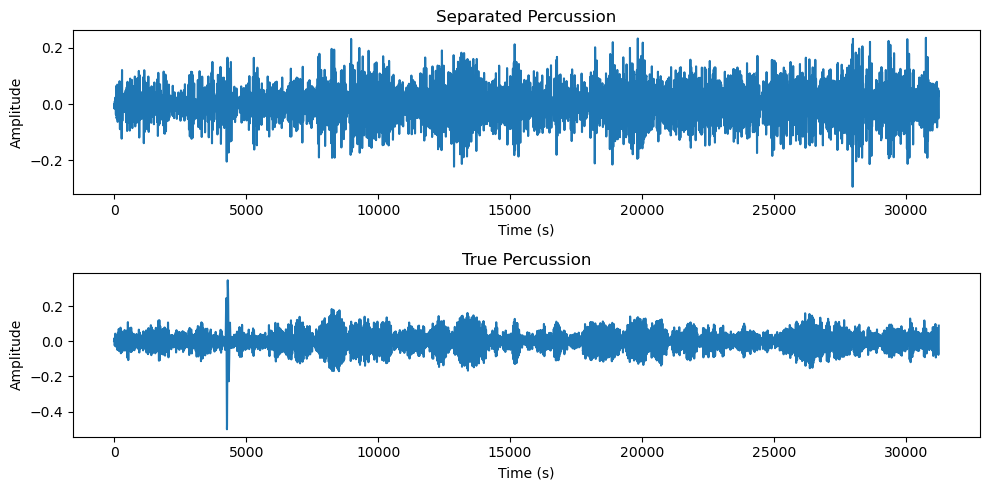

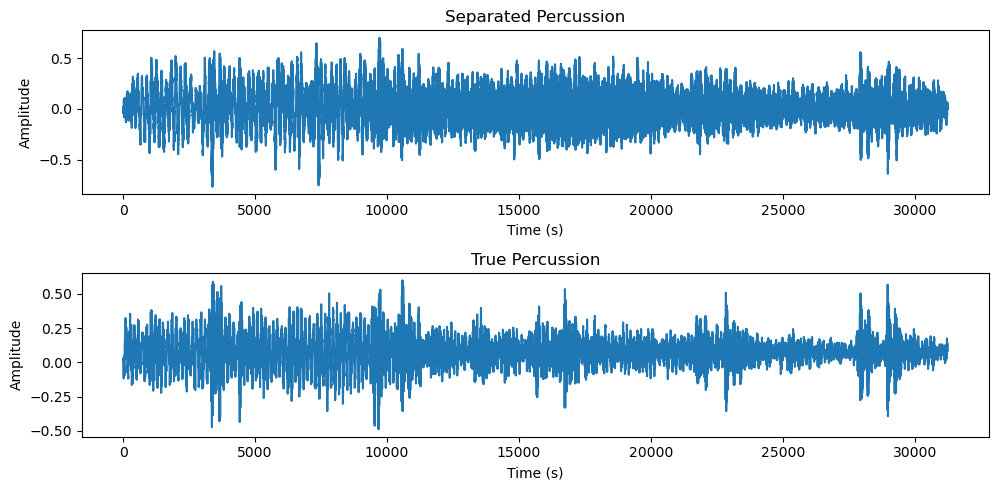

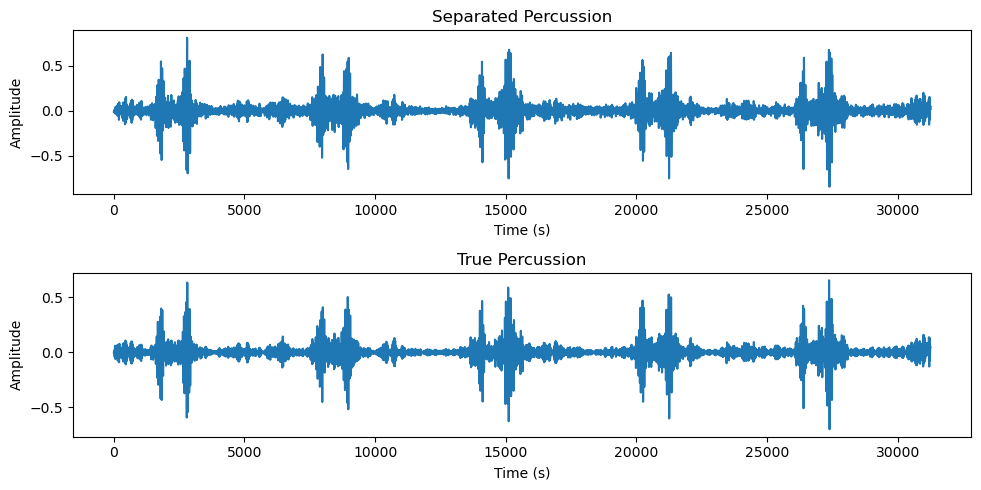

In [ ]:
# %%

def energy_ratio(true_audio, separated_audio):
    true_energy = np.sum(true_audio ** 2)
    separated_energy = np.sum(separated_audio ** 2)
    ratio = separated_energy / true_energy
    return ratio

energy_ratios = []
for i in range(12):
    energy_ratios.append(energy_ratio(percussion_audio[i].cpu().numpy(), percussion_sep[i].detach().cpu().numpy()))
    
energy_ratios = np.array(energy_ratios)
print(f"Energy Ratios: {energy_ratios}")

highest_ratio_indices = np.argsort(energy_ratios)[-3:]
for i in highest_ratio_indices:
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.title('Separated Percussion')
    plt.plot(percussion_sep[i].detach().cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.title('True Percussion')
    plt.plot(percussion_audio[i].cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

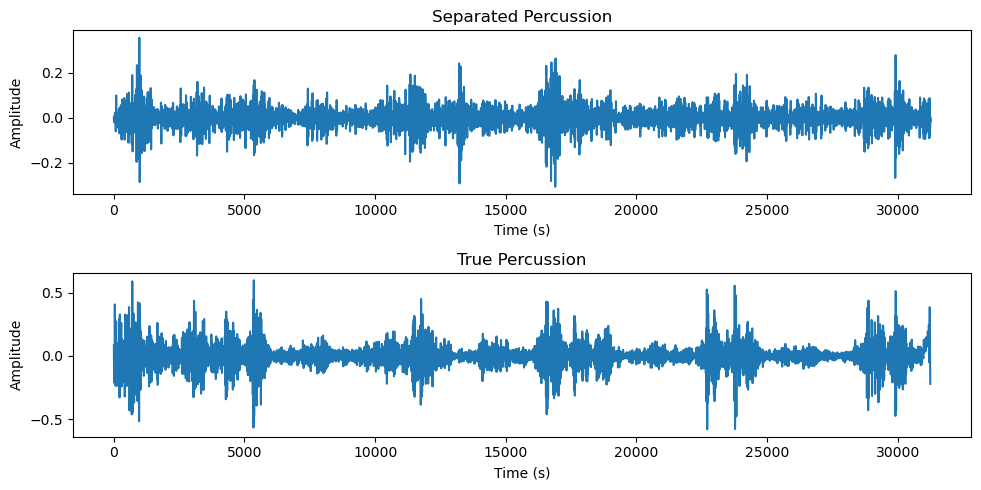

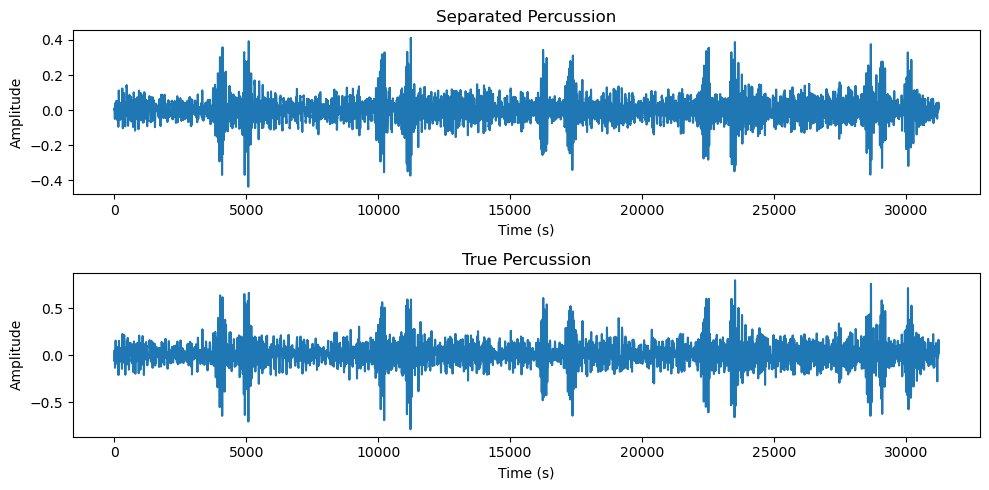

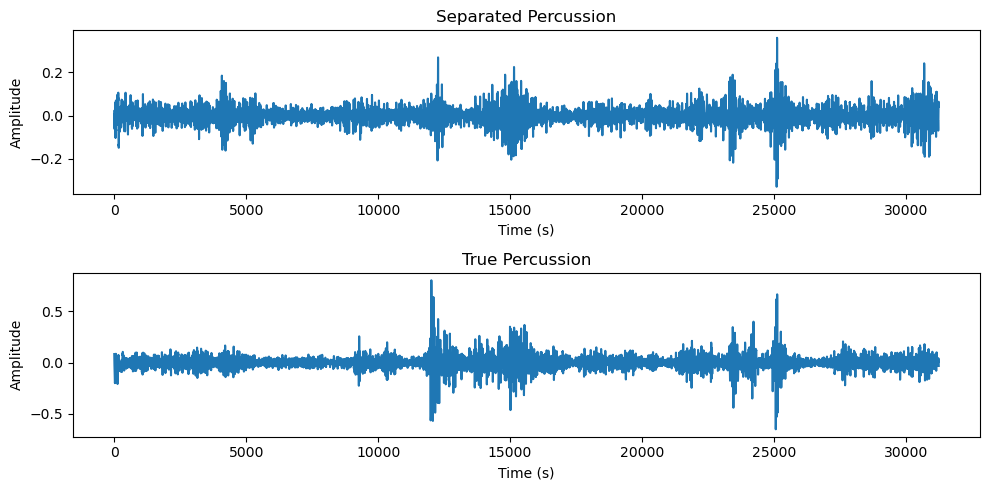

In [ ]:
#%%

lowest_ratio_indices = np.argsort(energy_ratios)[:3]
for i in lowest_ratio_indices:
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.title('Separated Percussion')
    plt.plot(percussion_sep[i].detach().cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.title('True Percussion')
    plt.plot(percussion_audio[i].cpu().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

In [ ]:
lowest_ratio_indices

array([2, 1, 4], dtype=int64)

In [ ]:
energy_ratios

array([0.80744636, 0.2837963 , 0.2568728 , 0.37749192, 0.32610437,
       1.2192491 , 1.5444592 , 1.4512342 , 0.66499466, 1.1392395 ,
       0.330213  , 1.5686464 ], dtype=float32)

In [ ]:
np.argsort(energy_ratios)

array([ 2,  1,  4, 10,  3,  8,  0,  9,  5,  7,  6, 11], dtype=int64)

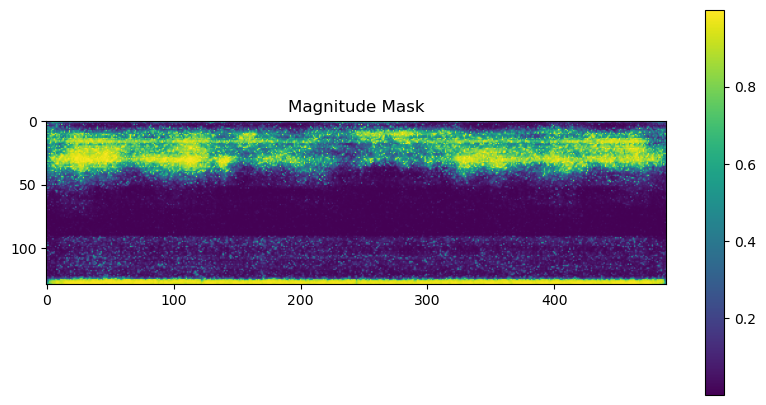

In [ ]:
# %%

#output the magnitude mask
plt.figure(figsize=(10, 5))
plt.title('Magnitude Mask')
plt.imshow(output['mag_mask'][0].detach().cpu().numpy())
plt.colorbar()
plt.show()

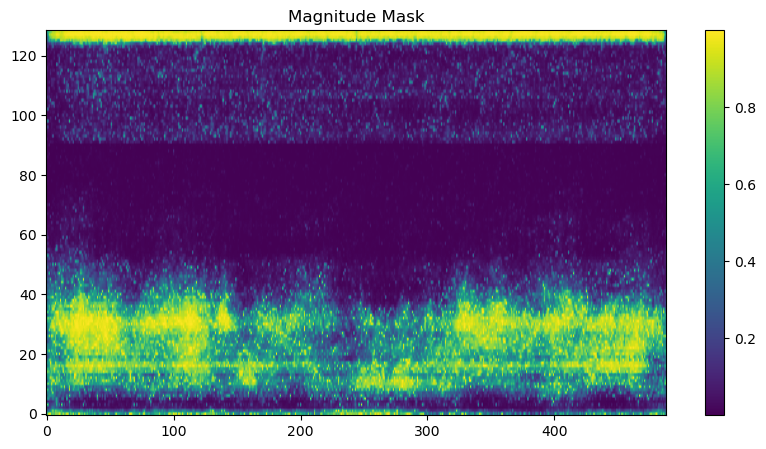

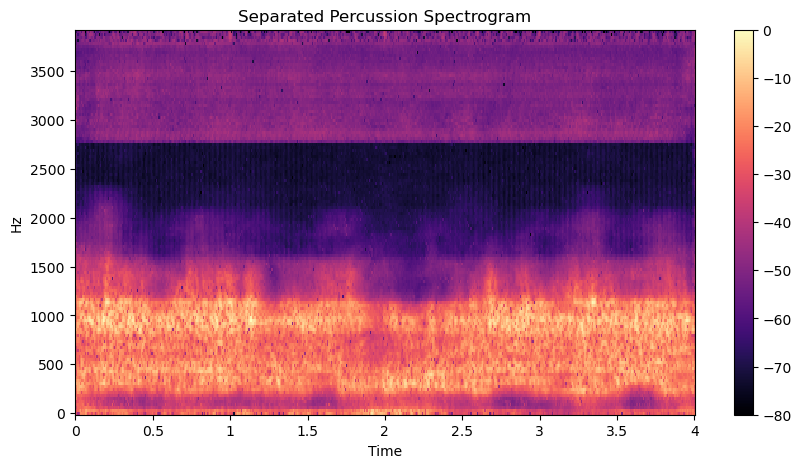

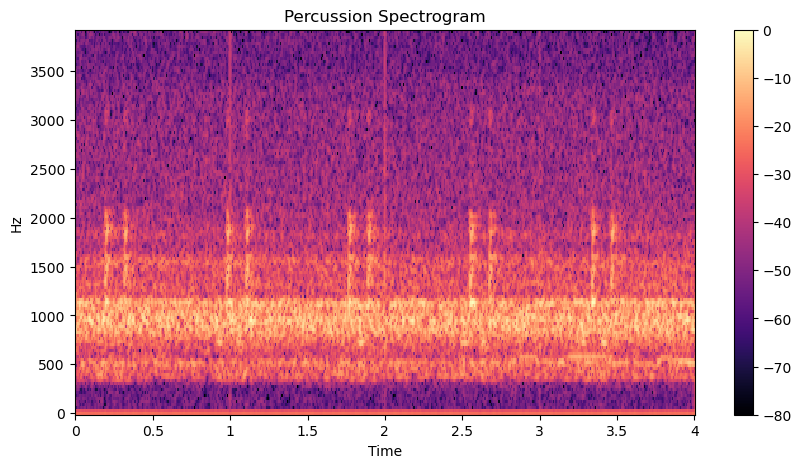

In [ ]:
# %%

#output the magnitude mask and the separated percussion spectrogram
plt.figure(figsize=(10, 5))
plt.title('Magnitude Mask')
plt.imshow(output['mag_mask'][0].detach().cpu().numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Separated Percussion Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(sep_output[0].detach().cpu().numpy()), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Percussion Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(true_percussion_stft[0].detach().cpu().numpy()), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)
plt.colorbar()
plt.show()

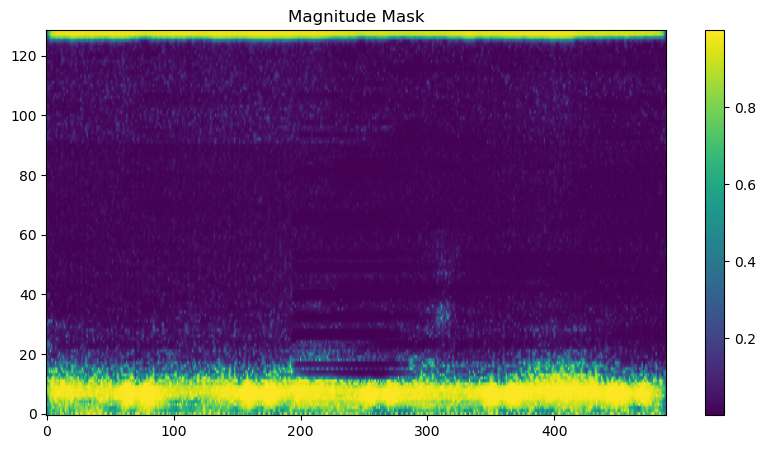

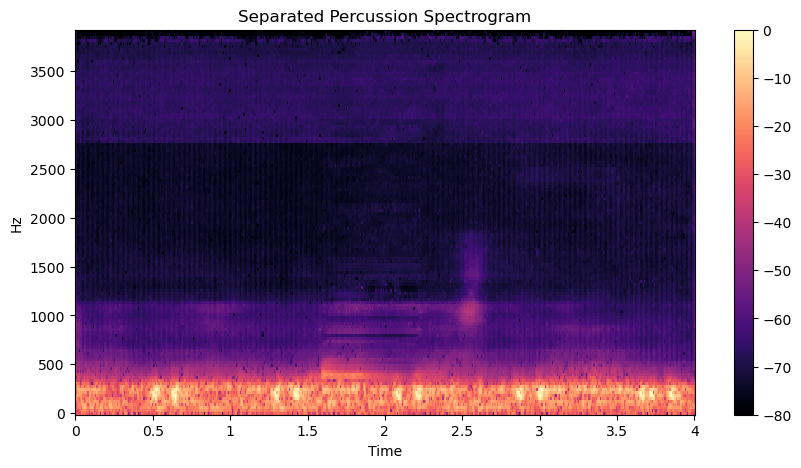

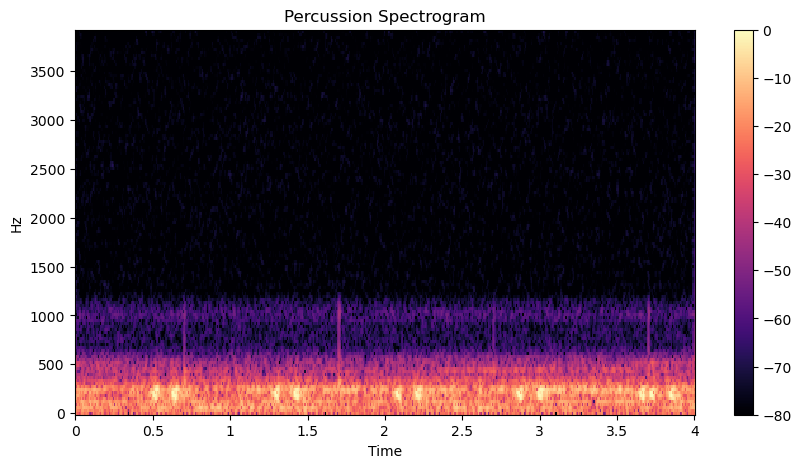

In [ ]:
# %%

#output the magnitude mask and the separated percussion spectrogram
plt.figure(figsize=(10, 5))
plt.title('Magnitude Mask')
plt.imshow(output['mag_mask'][1].detach().cpu().numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Separated Percussion Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(sep_output[1].detach().cpu().numpy()), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Percussion Spectrogram')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(true_percussion_stft[1].detach().cpu().numpy()), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=7812, n_fft=256, hop_length=64)
plt.colorbar()
plt.show()